In [1]:
import sys
from pathlib import Path
import os
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

In [2]:
import schemdraw
from schemdraw import flow

import pandas as pd
import numpy as np

from lifelines import KaplanMeierFitter
#from lifelines_fix import add_at_risk_counts
from lifelines.plotting import add_at_risk_counts
from lifelines import AalenJohansenFitter
import warnings

import matplotlib.pyplot as plt 
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
%matplotlib inline

In [3]:
from matplotlib.pyplot import Text

# Loading Data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/maia-sh/direcct-analysis/main/data/reporting/kaplan-meier-time-to-pub.csv?token=GHSAT0AAAAAAB5S2YBIYUVFOOYJG2AATYXSZBVHIFQ')
df.head()

,id,date_completion,date_cutoff,publication_any,publication_article,publication_preprint,publication_summary,publication_interim_any,date_publication_any,date_publication_article,date_publication_preprint,date_publication_summary,date_publication_interim_any,time_publication_any,time_publication_article,time_publication_preprint,time_publication_summary,time_publication_interim_any
0,tri00002,2020-04-30,2021-08-15,True,True,True,False,True,2020-03-23,2020-05-19,2020-03-23,NaN,2020-03-23,-38,19,-38,472,-38
1,tri00005,2020-07-01,2021-08-15,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,410,410,410,410,410
2,tri00006,2020-04-30,2021-08-15,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,472,472,472,472,472
3,tri00010,2020-06-01,2021-08-15,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,440,440,440,440,440
4,tri00011,2020-06-01,2021-08-15,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,440,440,440,440,440


In [5]:
#Making a copy to mess around with
df2 = df.copy()

In [6]:
results_cutoff = pd.to_datetime('2021-08-15')

To Do: 
1. Remove dates after August 15th 2021 (or other date this gets changes to) XX
2. Fix what this does to other columns XX
2. Zero out negative follow-ups XX (doing this per graph)
3. Create columns accounting for censorship XX
4. Make date into dates XX
5. Prepare for A-J XX
6. Write sanity checks

# Making Dates into Dates

In [7]:
for x in df2.columns:
    if 'date' in x:
        df2[x] = pd.to_datetime(df2[x])

# Joining in IDs

In [8]:
df_reg = pd.read_csv('https://raw.githubusercontent.com/maia-sh/direcct-analysis/main/data/reporting/registrations.csv?token=GHSAT0AAAAAAB5S2YBJNSWM6KQE5D6TM7RKZBVHJBQ')

In [9]:
df2 = df2.merge(df_reg[['id', 'trn']], on='id', how='left')

# Filtering out post cut-off dates

In [10]:
df2['date_publication_preprint_adj'] = np.where(df2.date_publication_preprint > results_cutoff, pd.NaT, df2.date_publication_preprint)
df2['date_publication_preprint_adj'] = pd.to_datetime(df2['date_publication_preprint_adj'])

In [11]:
df2['date_publication_article_adj'] = np.where(df2.date_publication_article > results_cutoff, pd.NaT, df2.date_publication_article)
df2['date_publication_article_adj'] = pd.to_datetime(df2['date_publication_article_adj'])

In [12]:
df2['date_publication_summary_adj'] = np.where(df2.date_publication_summary > results_cutoff, pd.NaT, df2.date_publication_summary)
df2['date_publication_summary_adj'] = pd.to_datetime(df2['date_publication_summary_adj'])

# Then we need to re-create the other columns from that adjusted data

In [13]:
#Reporting variables
df2['publication_preprint_adj'] = np.where(df2['date_publication_preprint_adj'].notnull(), True, False)
df2['publication_article_adj'] = np.where(df2['date_publication_article_adj'].notnull(), True, False)
df2['publication_summary_adj'] = np.where(df2['date_publication_summary_adj'].notnull(), True, False)
df2['publication_any_adj'] = np.where(df2['publication_preprint_adj'] | df2['publication_article_adj'] | df2['publication_summary_adj'], True, False)

In [14]:
#Time to reporting by route
df2['time_publication_preprint_adj'] = np.where(df2.publication_preprint_adj, 
                                                (df2.date_publication_preprint_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

df2['time_publication_article_adj'] = np.where(df2.publication_article_adj, 
                                                (df2.date_publication_article_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

df2['time_publication_summary_adj'] = np.where(df2.publication_summary_adj, 
                                                (df2.date_publication_summary_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

In [15]:
#Time to reporting any

df2['time_reporting_any_adj'] = df2[['time_publication_preprint_adj', 'time_publication_article_adj', 'time_publication_summary_adj']].min(axis=1)

# Overall Reporting Rate

In [16]:
df2.columns

Index(['id', 'date_completion', 'date_cutoff', 'publication_any',
       'publication_article', 'publication_preprint', 'publication_summary',
       'publication_interim_any', 'date_publication_any',
       'date_publication_article', 'date_publication_preprint',
       'date_publication_summary', 'date_publication_interim_any',
       'time_publication_any', 'time_publication_article',
       'time_publication_preprint', 'time_publication_summary',
       'time_publication_interim_any', 'trn', 'date_publication_preprint_adj',
       'date_publication_article_adj', 'date_publication_summary_adj',
       'publication_preprint_adj', 'publication_article_adj',
       'publication_summary_adj', 'publication_any_adj',
       'time_publication_preprint_adj', 'time_publication_article_adj',
       'time_publication_summary_adj', 'time_reporting_any_adj'],
      dtype='object')

In [17]:
overall_cols = ['id', 'trn', 'date_completion', 'date_publication_preprint_adj', 'date_publication_article_adj', 
                'date_publication_summary_adj', 'publication_preprint_adj', 'publication_article_adj', 
                'publication_summary_adj', 'publication_any_adj', 'time_publication_preprint_adj', 
                'time_publication_article_adj','time_publication_summary_adj', 'time_reporting_any_adj']

In [18]:
adjusted_data = df2[overall_cols].reset_index(drop=True)

In [19]:
adjusted_data['preprint_to_jounral'] = (adjusted_data.date_publication_article_adj - adjusted_data.date_publication_preprint_adj) / pd.Timedelta('1 day')

In [20]:
adjusted_data[(adjusted_data.preprint_to_jounral <= 0)]

,id,trn,date_completion,date_publication_preprint_adj,date_publication_article_adj,date_publication_summary_adj,publication_preprint_adj,publication_article_adj,publication_summary_adj,publication_any_adj,time_publication_preprint_adj,time_publication_article_adj,time_publication_summary_adj,time_reporting_any_adj,preprint_to_jounral
424,tri01280,NCT04329923,2020-11-11,2021-02-26,2020-09-30,2020-12-10,True,True,True,True,107.0,-42.0,29.0,-42.0,-149.0
976,tri03276,NCT04304053,2020-06-15,2020-07-16,2020-07-16,NaT,True,True,False,True,31.0,31.0,426.0,31.0,0.0
977,tri03276,EUCTR2020-001031-27,2020-06-15,2020-07-16,2020-07-16,NaT,True,True,False,True,31.0,31.0,426.0,31.0,0.0


In [21]:
adjusted_data[(adjusted_data.publication_preprint_adj == True) & 
              (adjusted_data.publication_article_adj == True) & 
              (adjusted_data.preprint_to_jounral >= 0)]['preprint_to_jounral'].describe()

count    105.000000
mean     120.285714
std       89.836894
min        0.000000
25%       59.000000
50%       95.000000
75%      173.000000
max      557.000000
Name: preprint_to_jounral, dtype: float64

# Data Handling for A-J curves for time to preprint with article pub as a competing risk

In [22]:
competing_risks = df2[['id', 
                      'date_completion', 
                      'date_publication_article_adj', 
                      'date_publication_preprint_adj', 
                      'time_publication_article_adj', 
                      'time_publication_preprint_adj']].reset_index(drop=True)

In [23]:
cr_conds = [
    competing_risks.time_publication_preprint_adj <= competing_risks.time_publication_article_adj,
    (competing_risks.date_publication_article_adj.notnull() & competing_risks.date_publication_preprint_adj.isna())]

cr_out = [competing_risks.time_publication_preprint_adj, competing_risks.time_publication_article_adj]

competing_risks['time_cr'] = np.select(cr_conds, cr_out)

cr_event_conds = [
    competing_risks.date_publication_preprint_adj.notnull(),
    competing_risks.date_publication_preprint_adj.isna() & competing_risks.date_publication_article_adj.notnull(),
    competing_risks.date_publication_preprint_adj.isna() & competing_risks.date_publication_article_adj.isna()]

cr_event_out = [1, 2, 0]

competing_risks['event_cr'] = np.select(cr_event_conds, cr_event_out)
competing_risks['time_cr'] = np.where(competing_risks['time_cr'] < 0, 0, competing_risks['time_cr'])

In [24]:
d = competing_risks[['time_cr', 'event_cr']].reset_index(drop=True)
d = d.set_index('time_cr')

In [25]:
aj = AalenJohansenFitter(seed=5236)

#This just hides the warning that data is randomly "jiggered" to break ties, which is fine.
#The seed for this is set above
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    aj.fit(competing_risks.time_cr, competing_risks.event_cr, event_of_interest=1)

In [26]:
aj_corrected = aj.cumulative_density_.reset_index()
aj_corrected = aj_corrected.set_index(aj_corrected.event_at.apply(round)).drop('event_at', axis=1)

In [27]:
d = aj_corrected.merge(d, how='outer', left_index=True, right_index=True)
d = d.loc[d['event_cr'] == 0].copy()

# Any Publication

In [28]:
any_pub = df2[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
any_pub['publication_any_adj'] = any_pub['publication_any_adj'].astype(int)
any_pub['time_reporting_any_adj'] = np.where(any_pub['time_reporting_any_adj'] < 0, 0, any_pub['time_reporting_any_adj'])

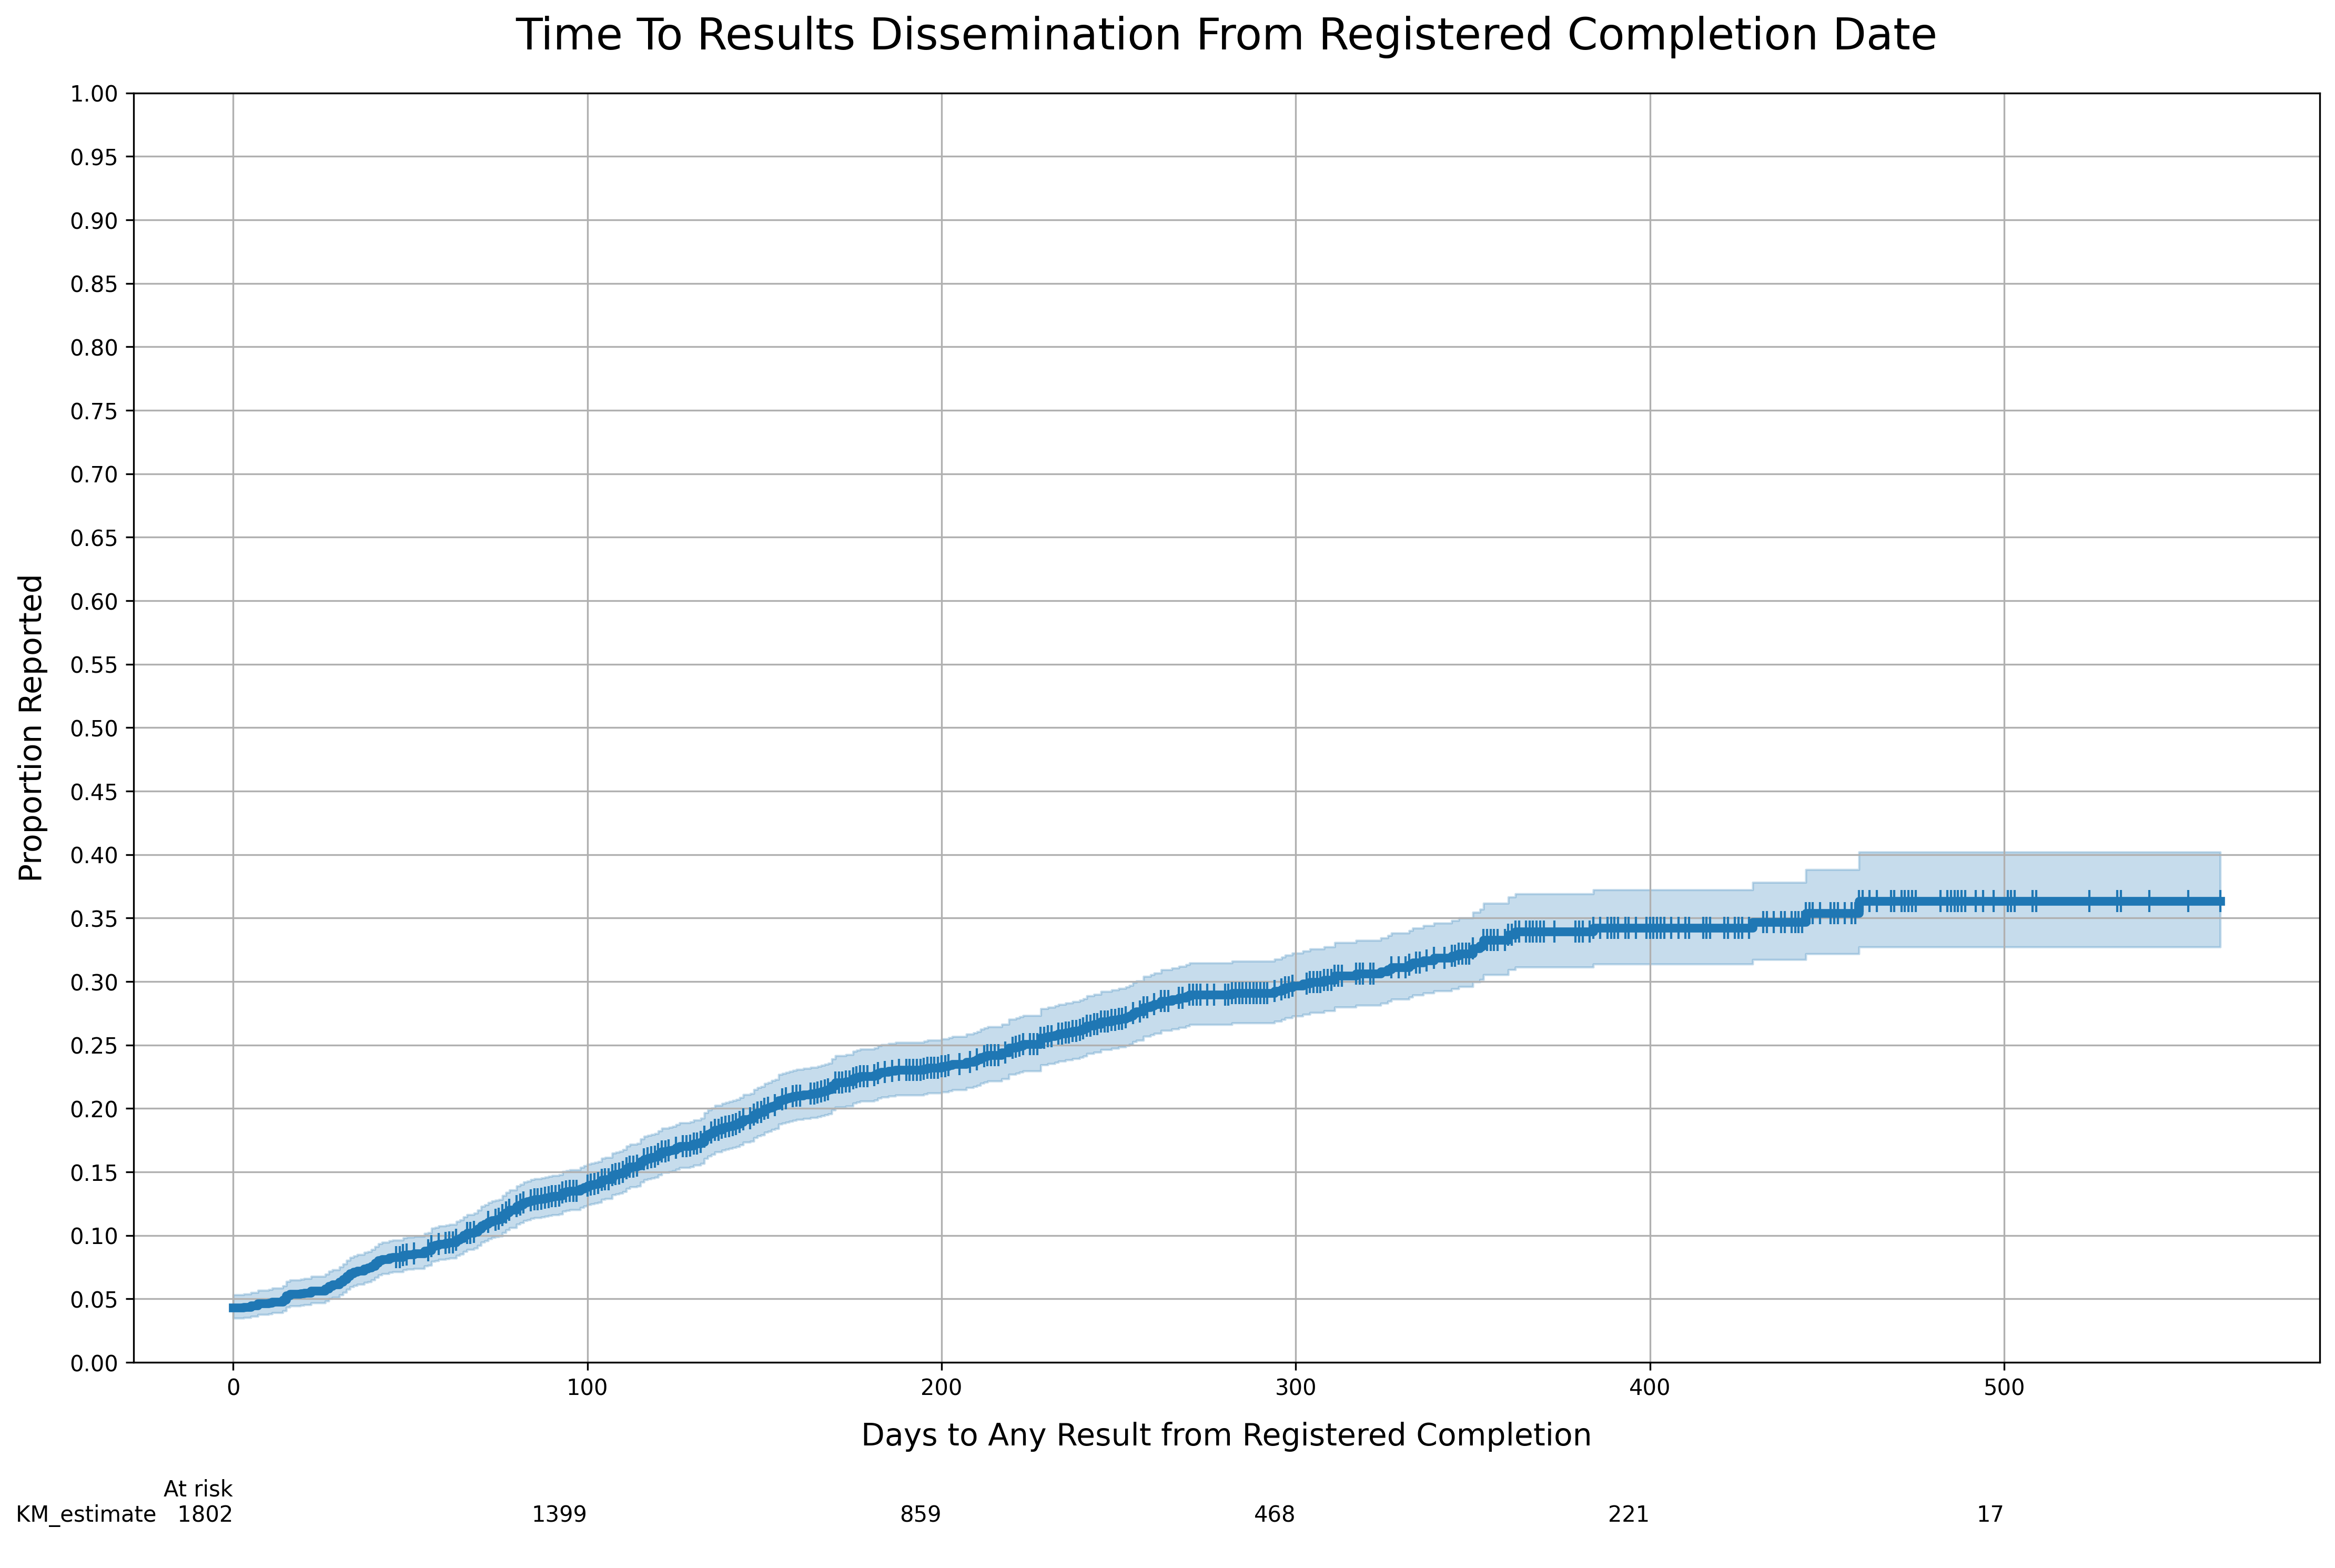

In [29]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(figsize = (10,10), dpi=300)
ax = plt.subplot()

T = any_pub.time_reporting_any_adj
E = any_pub.publication_any_adj

kmf_any = KaplanMeierFitter()
kmf_any.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_any.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=4)

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [30]:
#fig.savefig('time_any_pub.png')

# Article Publication

In [31]:
article_pub = df2[['publication_article_adj', 'time_publication_article_adj']].reset_index(drop=True)
article_pub['publication_article_adj'] = article_pub['publication_article_adj'].astype(int)
article_pub['time_publication_article_adj'] = np.where(article_pub['time_publication_article_adj'] < 0, 0, article_pub['time_publication_article_adj'])

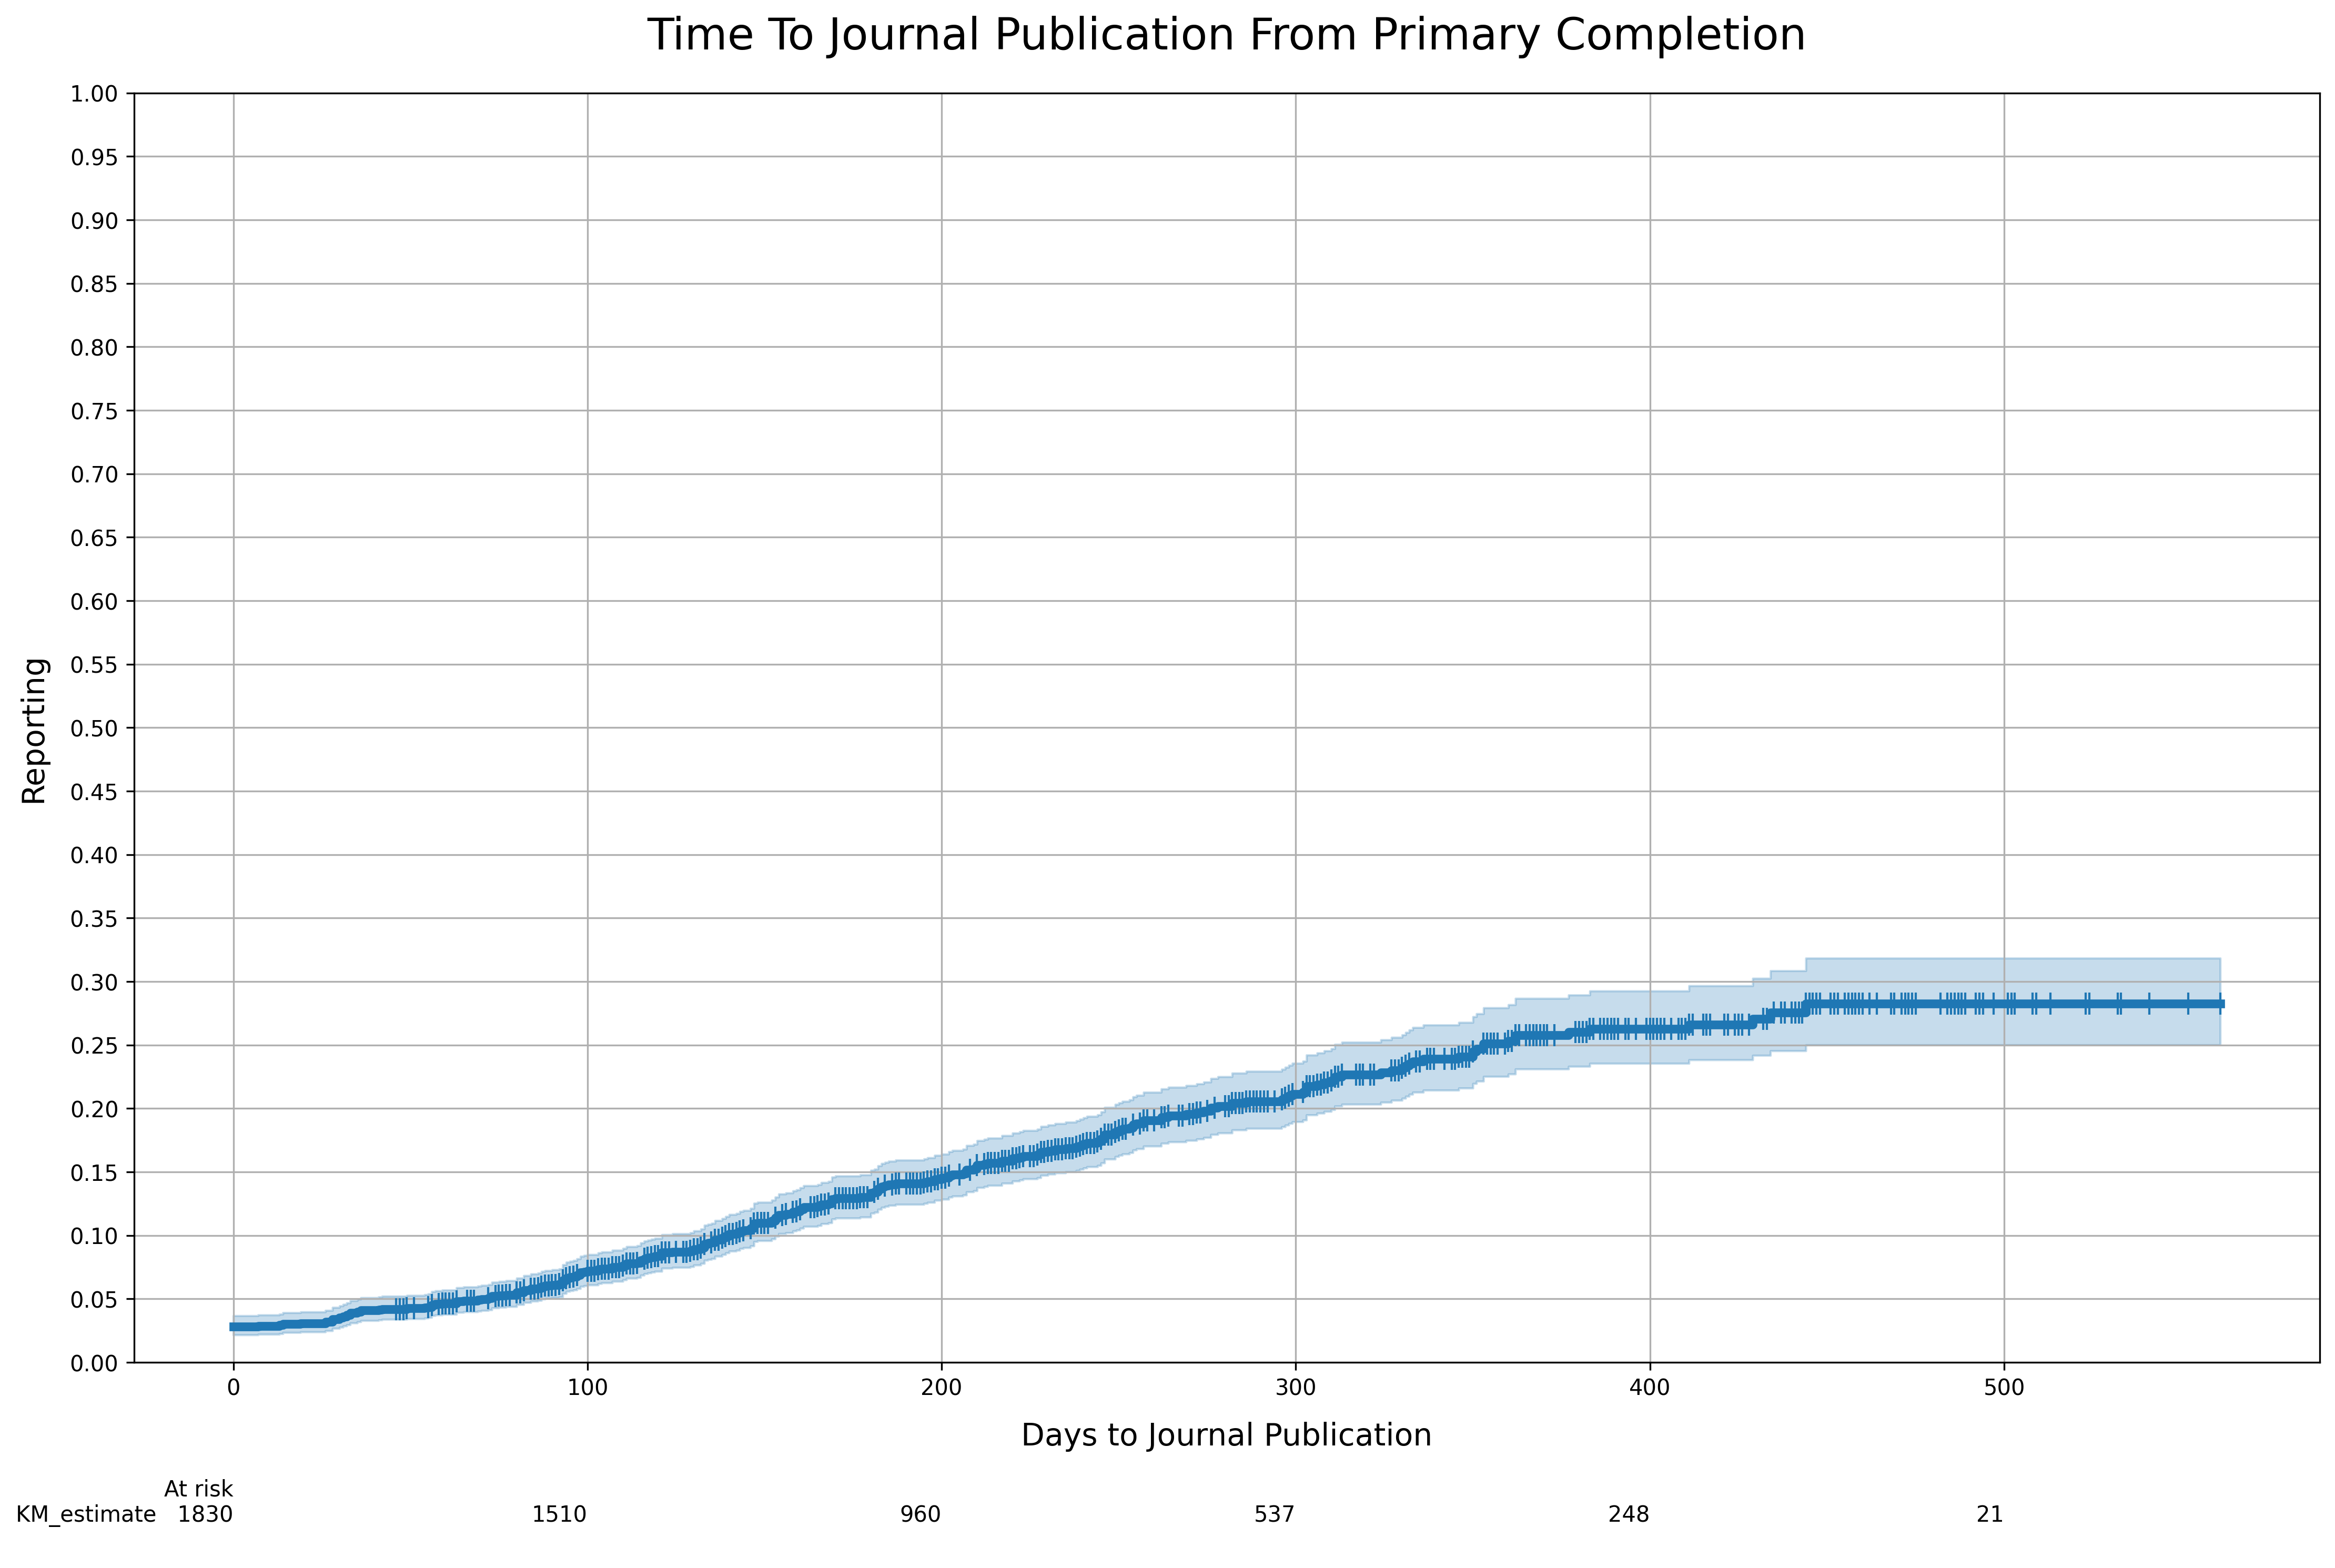

In [32]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = article_pub.time_publication_article_adj
E = article_pub.publication_article_adj

kmf_article = KaplanMeierFitter()
kmf_article.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_article.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=4)

ax.set_ylim([0, 1])

plt.title("Time To Journal Publication From Primary Completion", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_article, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [33]:
#fig.savefig('time_to_journal.png')

# Time to Preprint Publication (with article pub as competing risk)

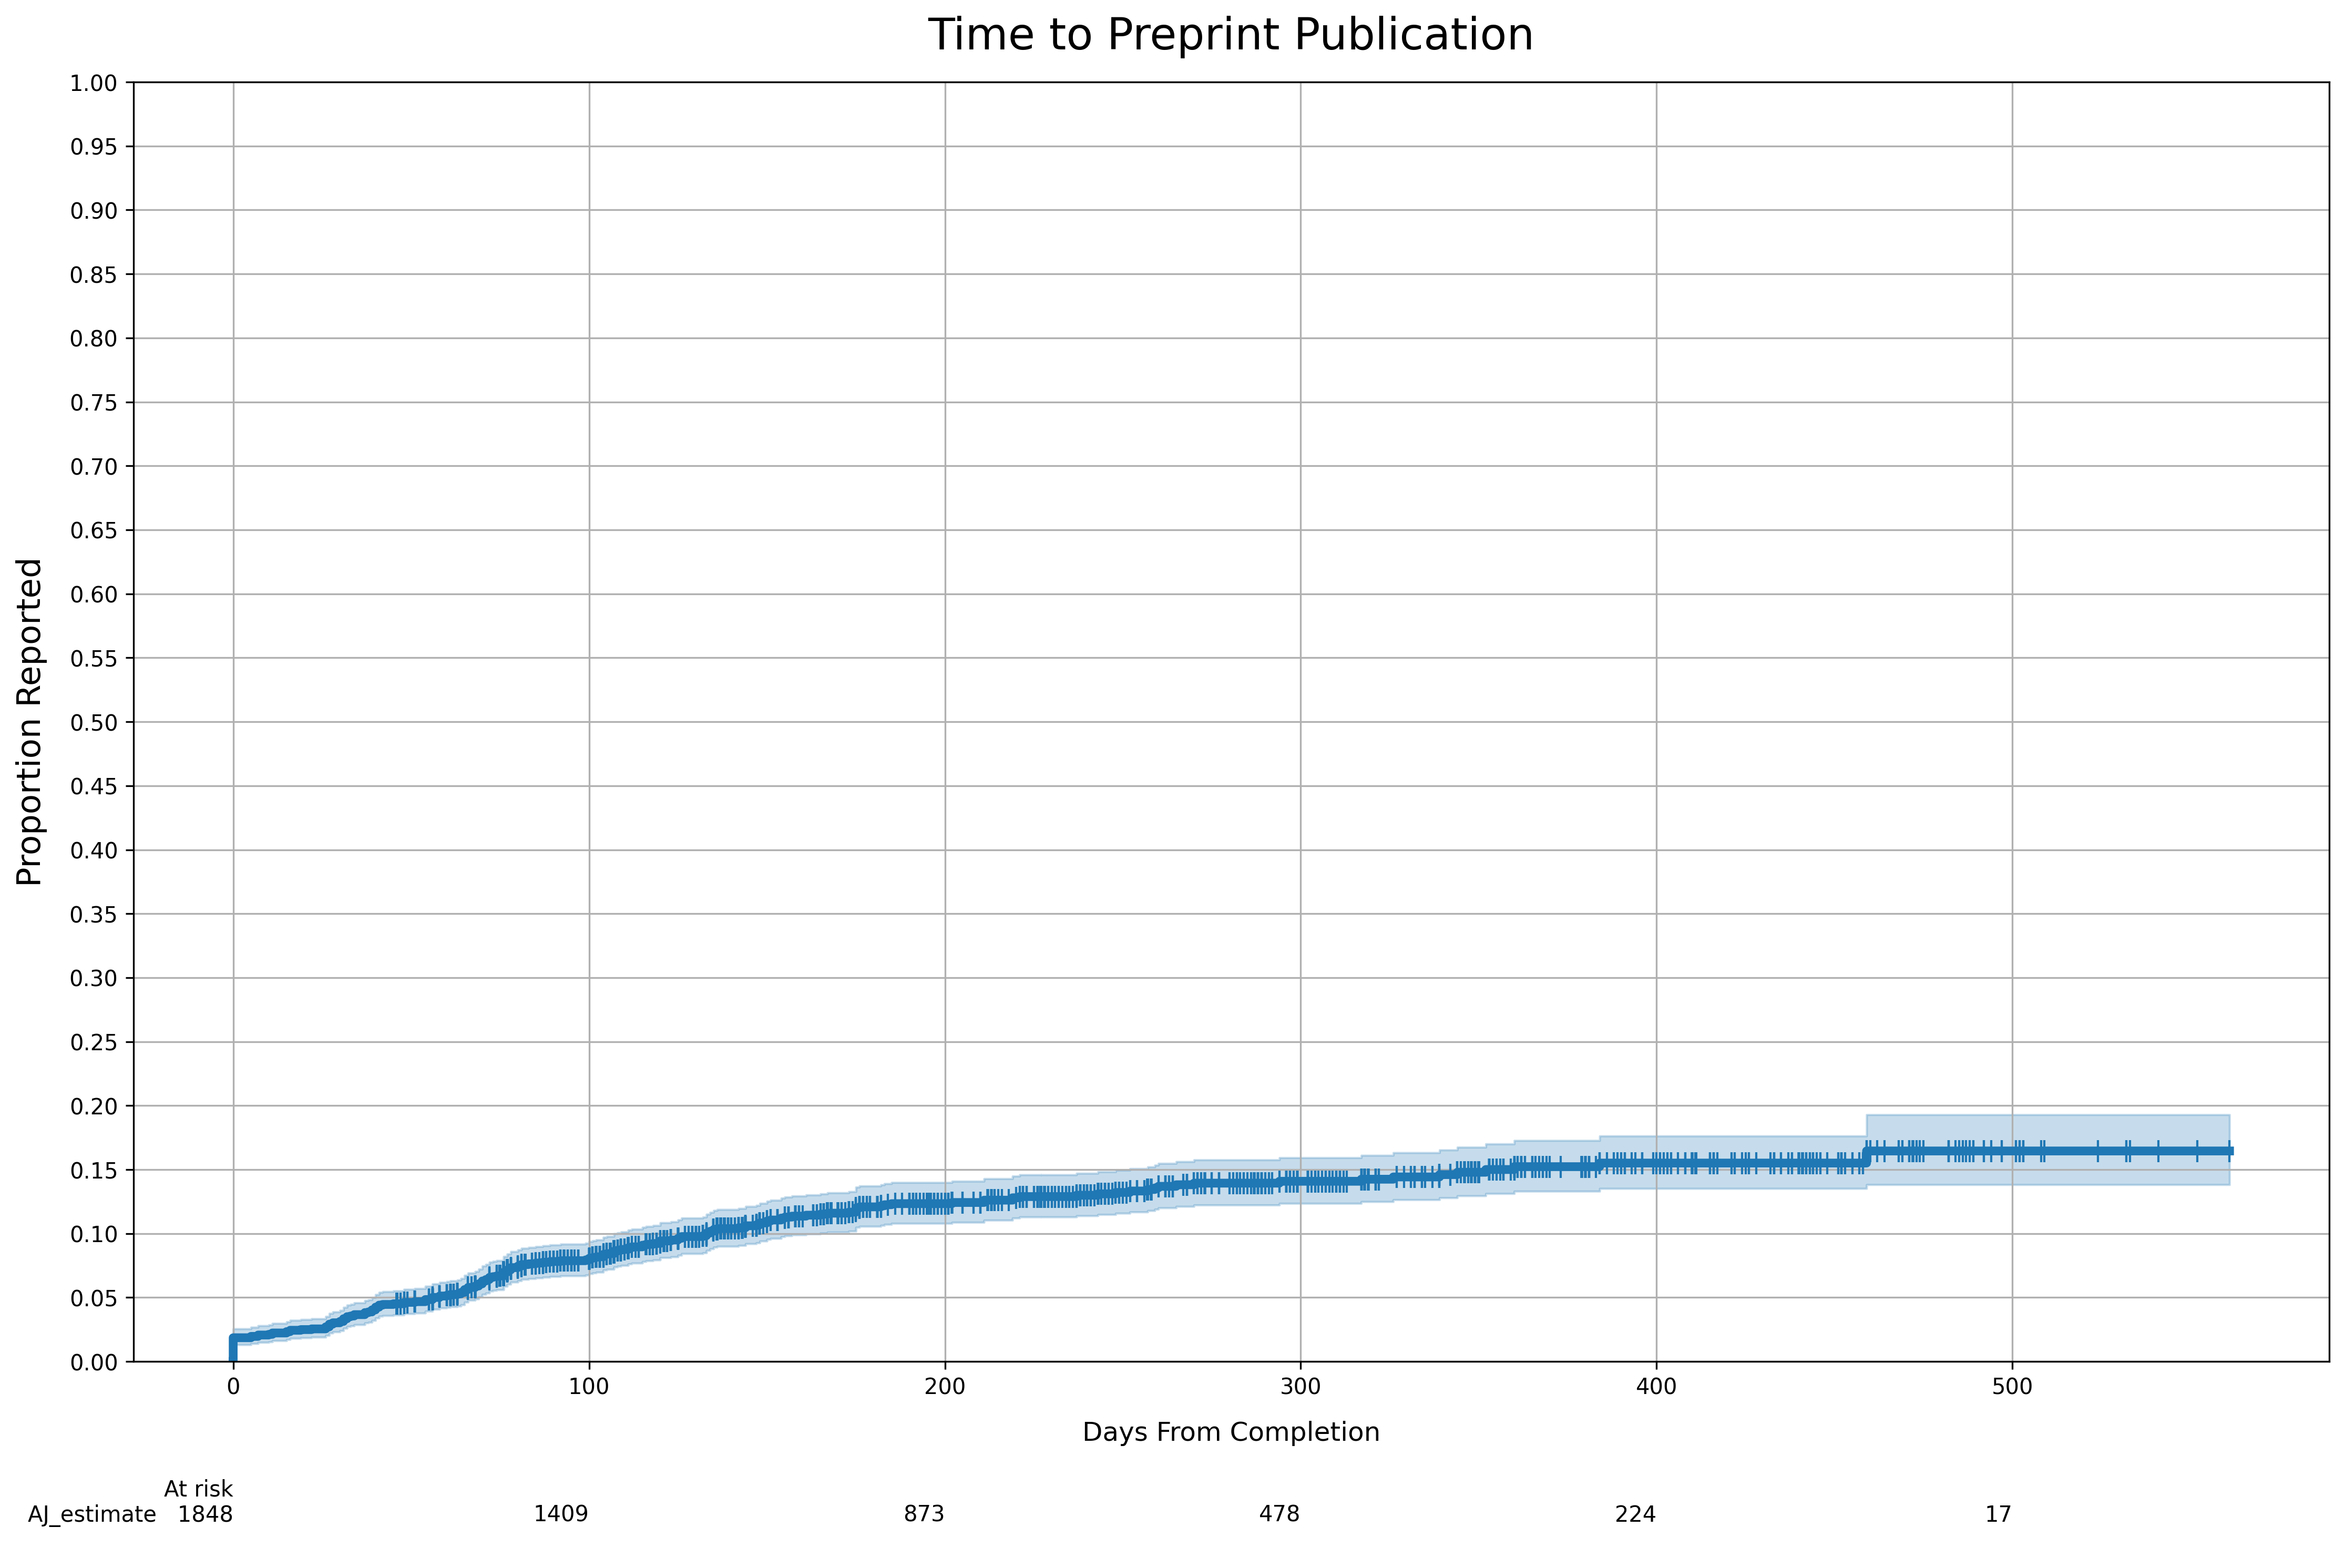

In [34]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

aj = AalenJohansenFitter(seed=10)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    aj.fit(competing_risks.time_cr, competing_risks.event_cr, event_of_interest=1)
aj.plot(yticks=yticks, figsize=(15,10), lw=4, legend=None, grid=True)
plt.plot(d.index, d['CIF_1'], '|', markersize=10, color='C0')

plt.title('Time to Preprint Publication', pad=15, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=15)
plt.xlabel('Days From Completion', labelpad=10, fontsize=12)

ax.set_ylim([0, 1])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(aj, rows_to_show = ['At risk'])
plt.tight_layout()
plt.show()

In [35]:
#fig.savefig('time_to_preprint_aj.png')

# Registry results
-We may want to restrict this only to registrations on registries that can accept registry results?

In [36]:
reg_pub = df2[['publication_summary_adj', 'time_publication_summary_adj']].reset_index(drop=True)
reg_pub['publication_summary_adj'] = reg_pub['publication_summary_adj'].astype(int)
reg_pub['time_publication_summary_adj'] = np.where(reg_pub['time_publication_summary_adj'] < 0, 0, reg_pub['time_publication_summary_adj'])

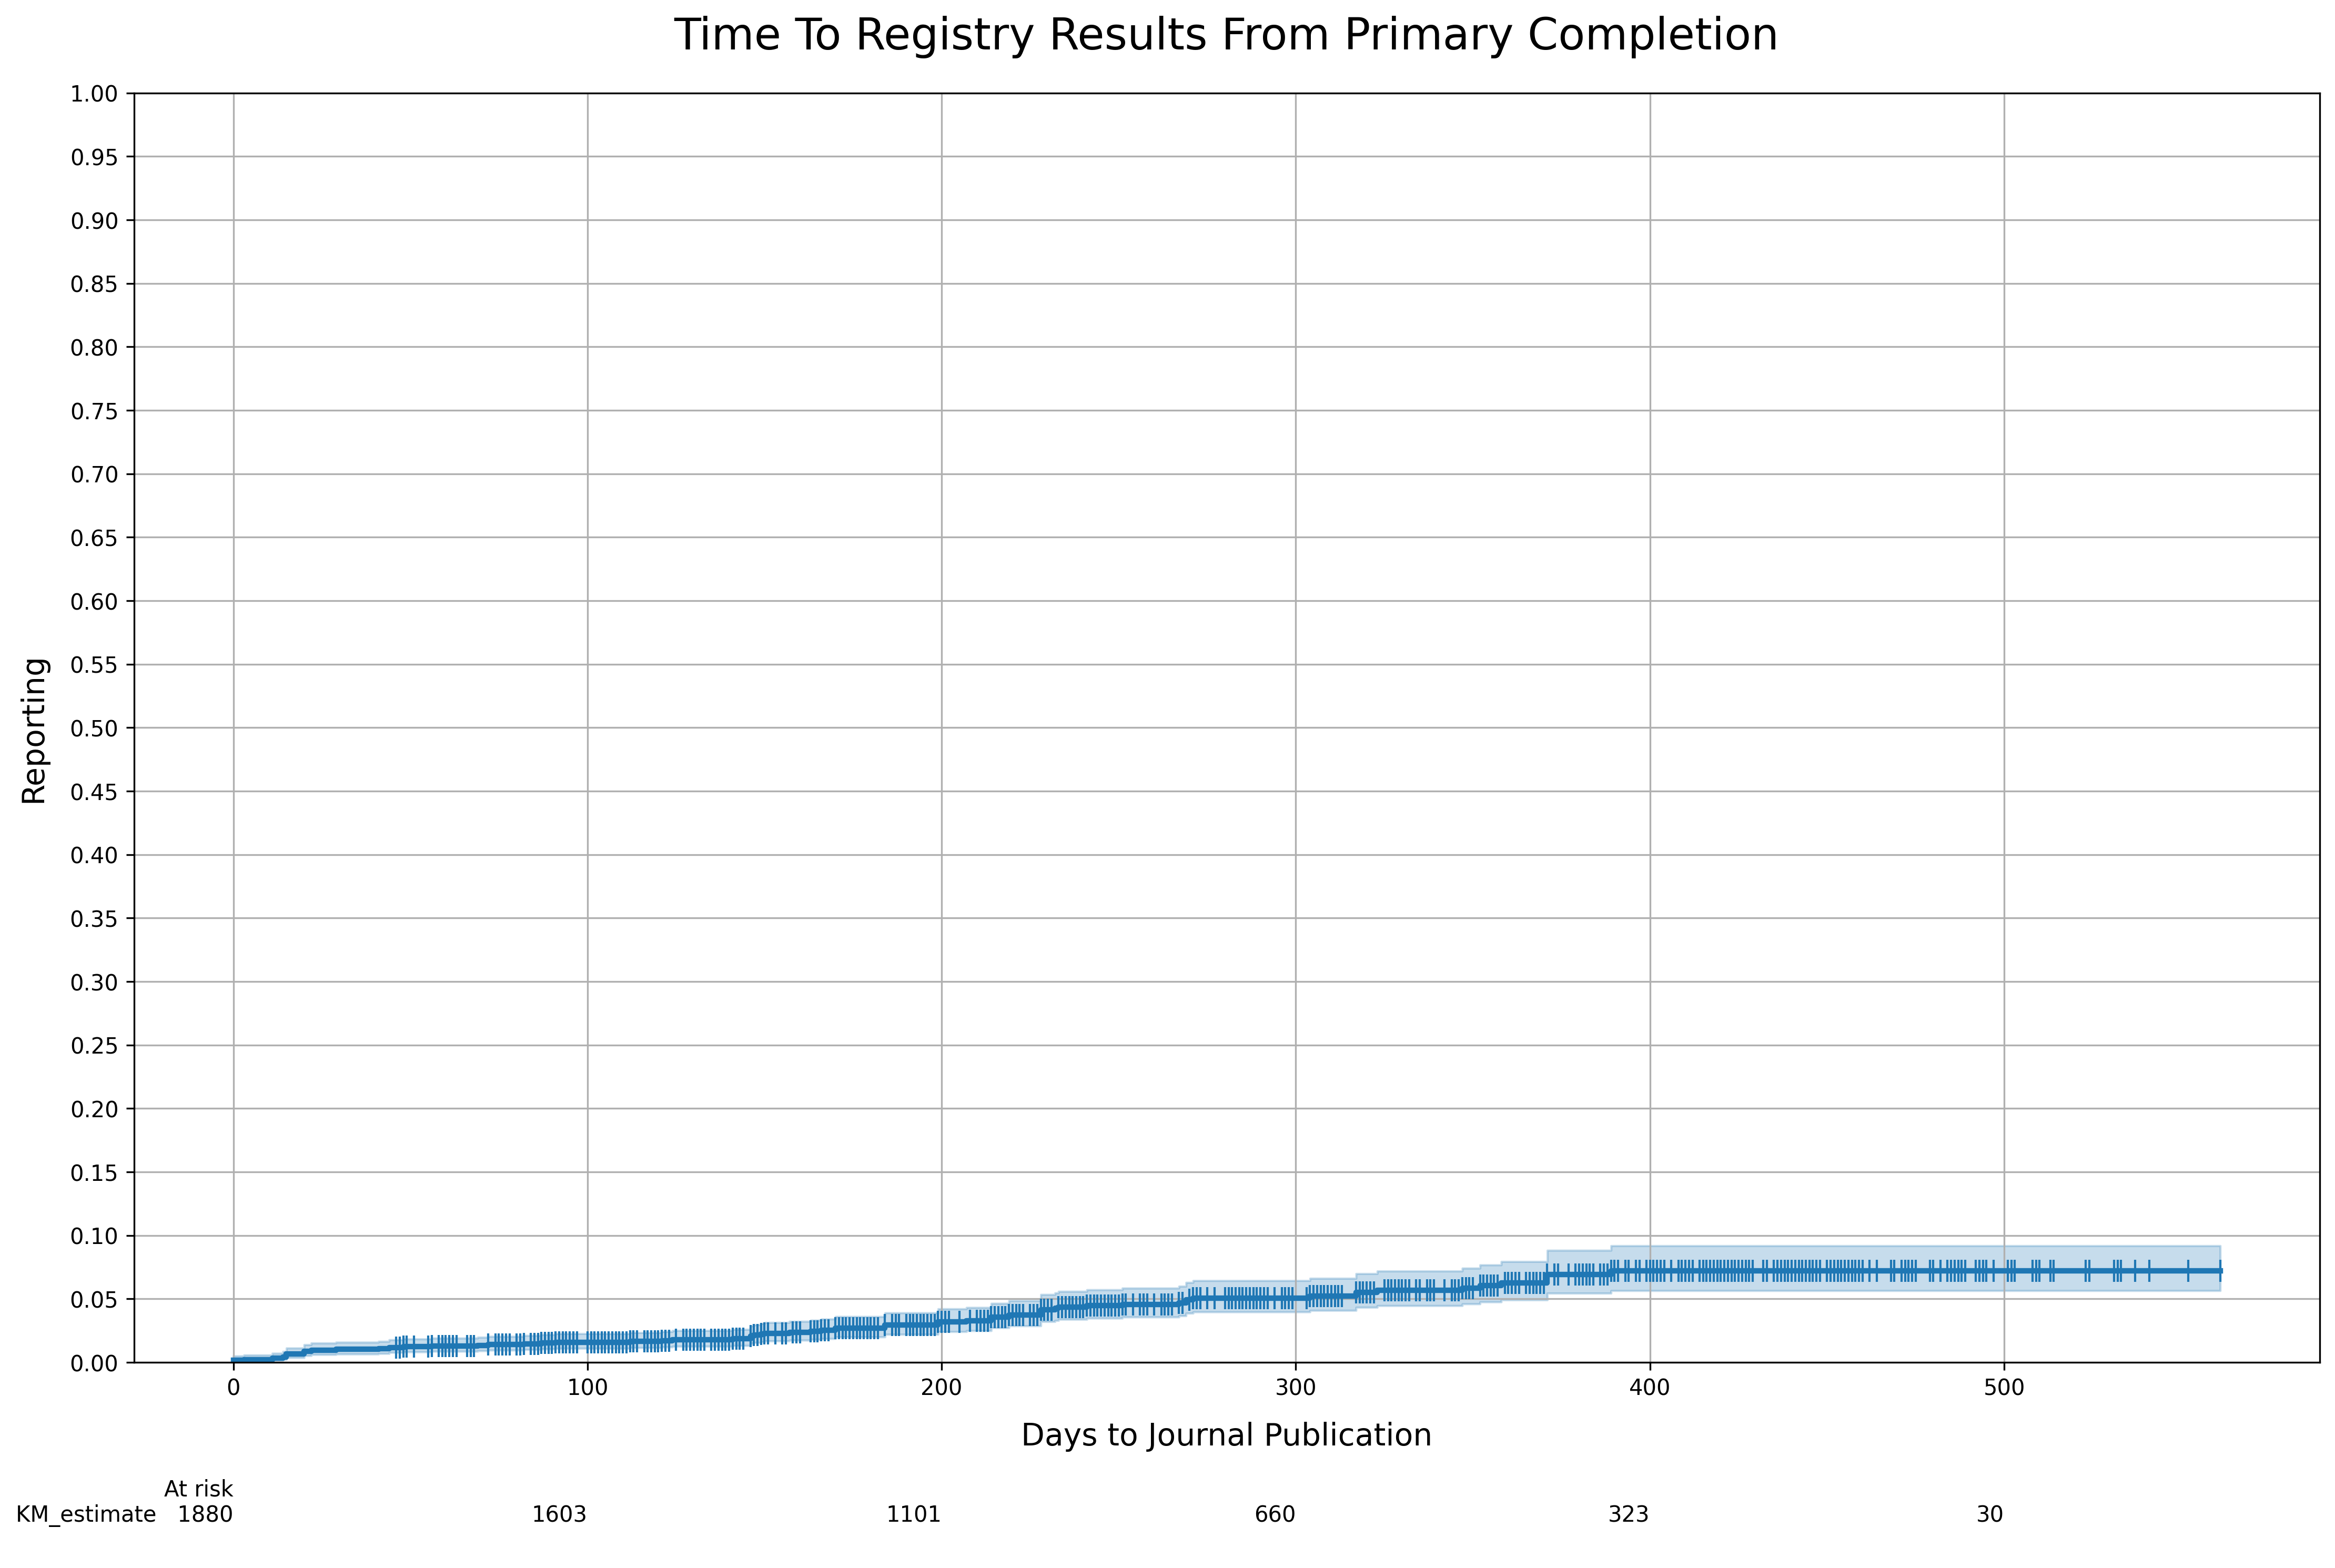

In [37]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = reg_pub.time_publication_summary_adj
E = reg_pub.publication_summary_adj

kmf_article = KaplanMeierFitter()
kmf_article.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_article.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Registry Results From Primary Completion", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_article, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Venn

In [38]:
venn_data = df2[['publication_preprint_adj', 'publication_article_adj', 'publication_summary_adj']].reset_index(drop=True)

In [39]:
prep = venn_data.publication_preprint_adj == True
art = venn_data.publication_article_adj == True
reg = venn_data.publication_summary_adj == True

In [40]:
len(venn_data[~art & reg & prep])

7

In [41]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
labels = ['Journal Articles', 'Registry Results', 'Preprints']

#Order of values: J, R, J+R, P, P+J, R+P, J+R+P

values = (len(venn_data[art & ~prep & ~reg]), 
          len(venn_data[~art & ~prep & reg]), 
          len(venn_data[art & ~prep & reg]), 
          len(venn_data[~art & prep & ~reg]), 
          len(venn_data[art & prep & ~reg]), 
          len(venn_data[~art & prep & reg]), 
          len(venn_data[art & prep & reg]))

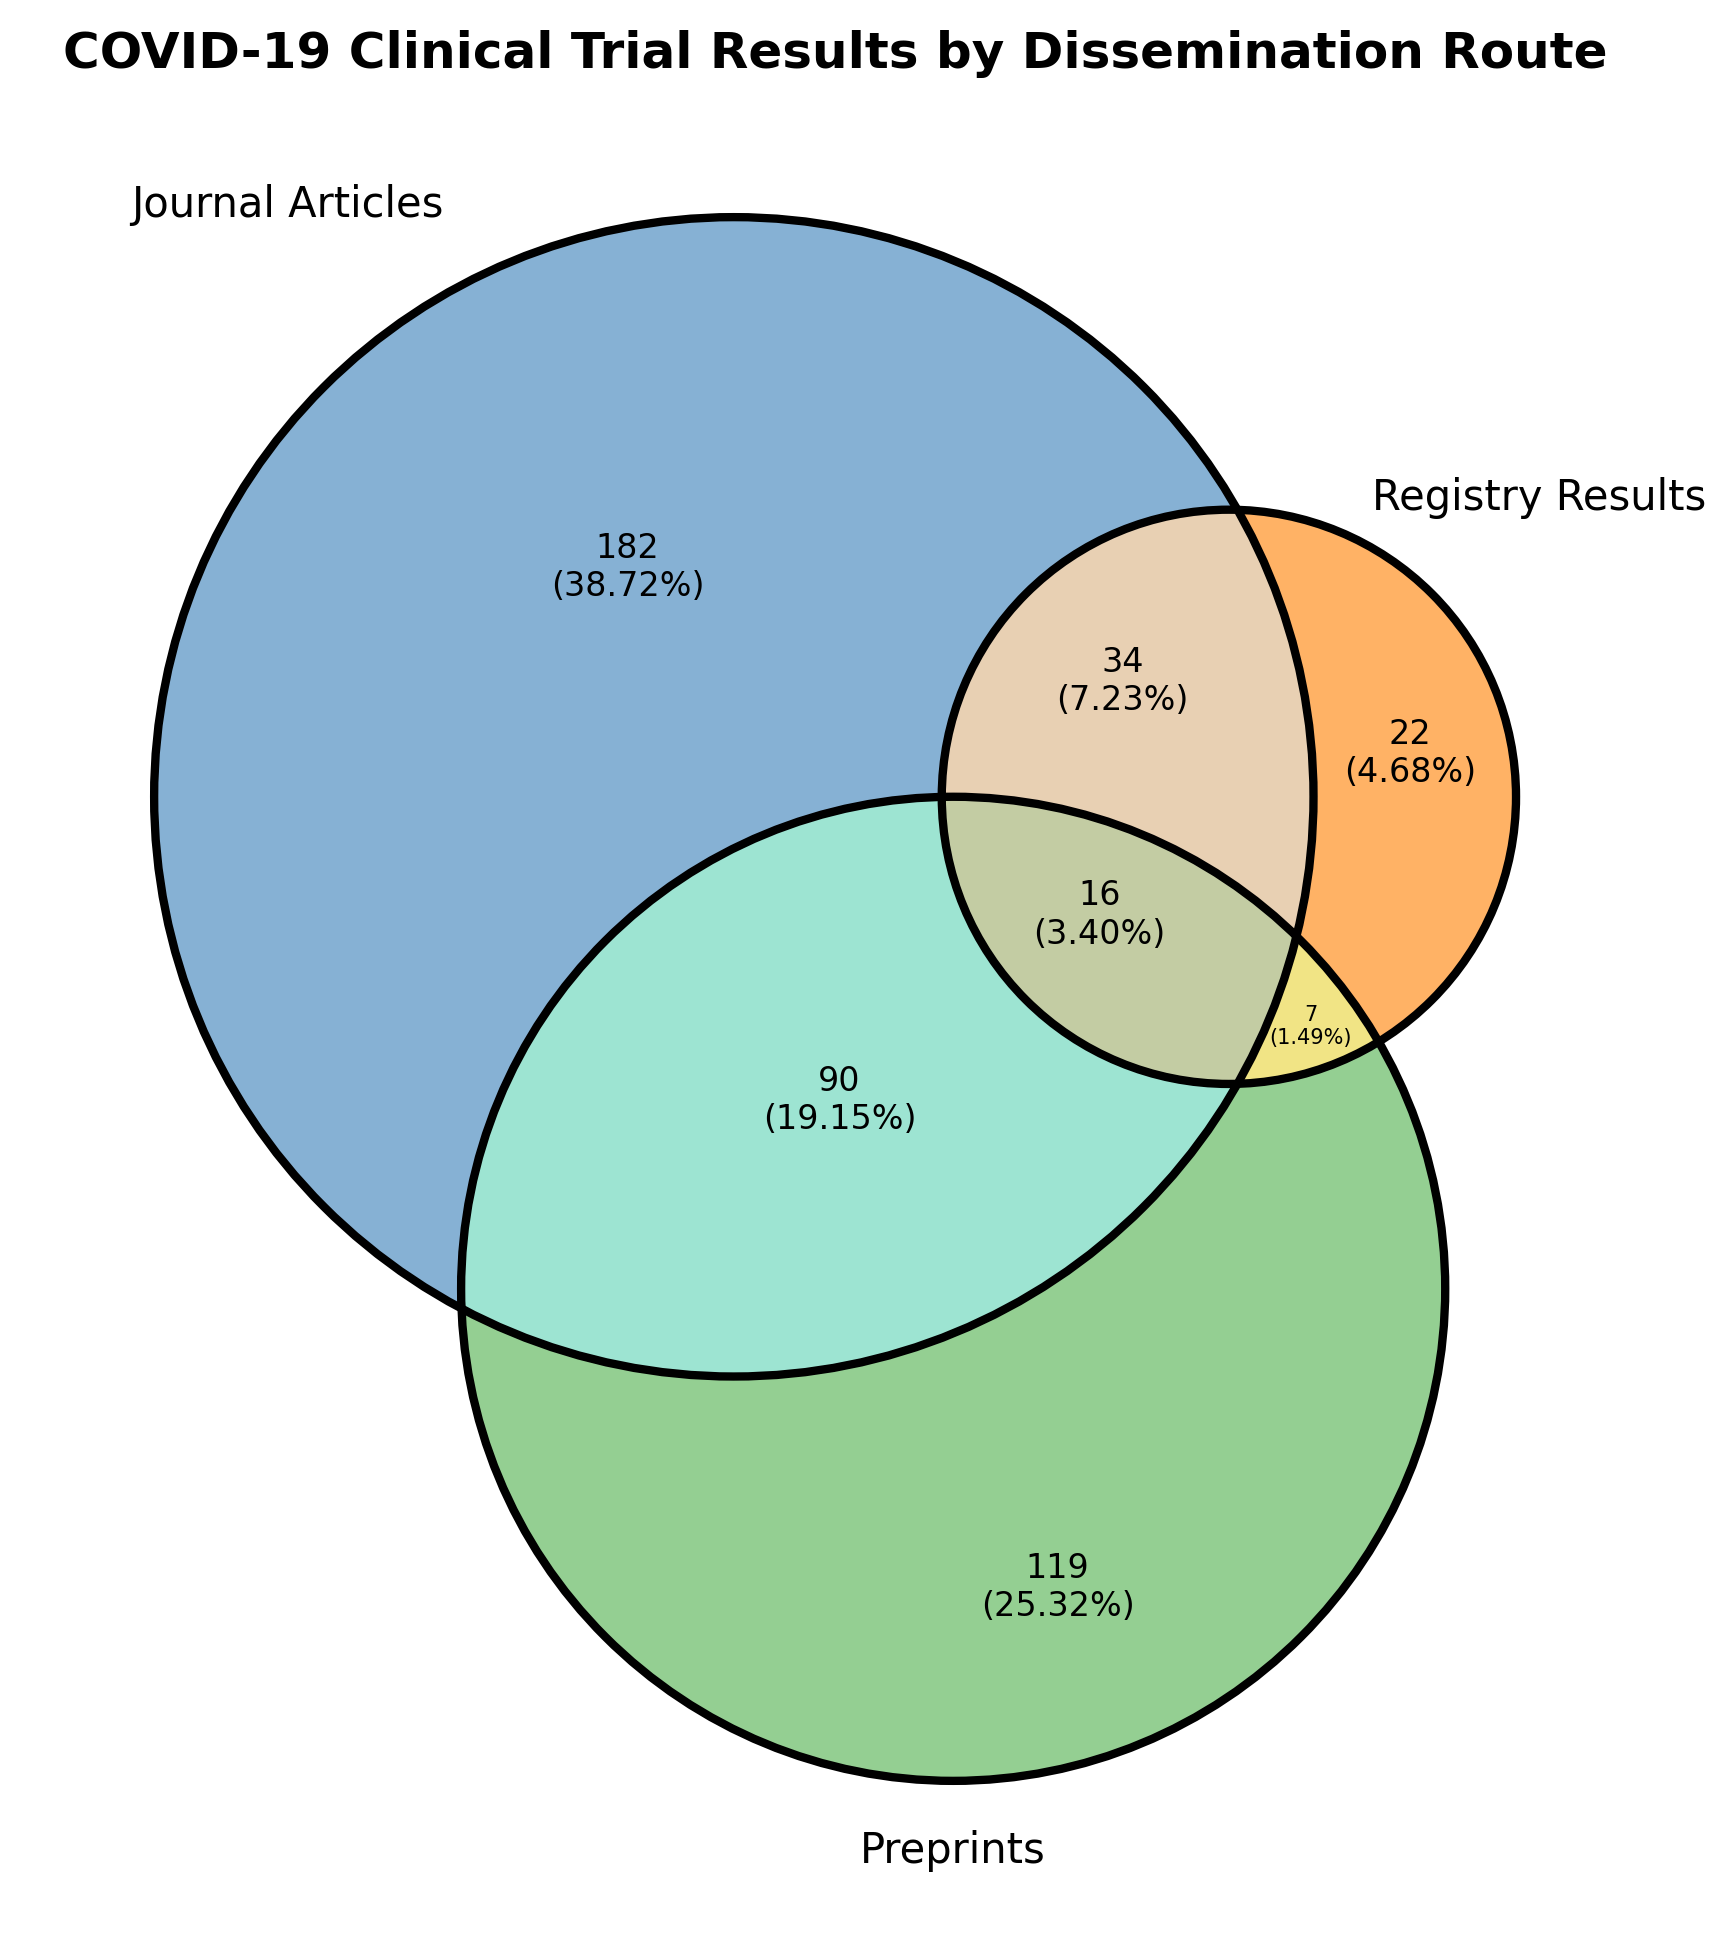

In [42]:
plt.figure(figsize=(8,8), dpi=300)
v1 = venn3(
    subsets = values, 
    set_labels = labels,
    set_colors = colors, 
    subset_label_formatter = lambda x: str(x) + "\n(" + f"{(x/sum(values)):1.2%}" + ")", 
    alpha = .6)

for text in v1.set_labels:
    text.set_fontsize(10)

for text in v1.subset_labels:
    if text == v1.subset_labels[-2]:
        text.set_fontsize(5)
    else:
        text.set_fontsize(8)

#Journal Only
v1.get_label_by_id("100").set_x(-0.2)
#All
v1.get_label_by_id("111").set_x(.18)
v1.get_label_by_id("111").set_y(.05)
#Registry + preprint
v1.get_label_by_id("011").set_y(-.04)
v1.get_label_by_id("011").set_x(.35)
#Registry Only
v1.get_label_by_id("010").set_x(.43)
v1.get_label_by_id("010").set_y(.18)

venn3_circles(values)
plt.title('COVID-19 Clinical Trial Results by Dissemination Route', fontweight='bold')
#plt.savefig('reporting_venn.png')
plt.show()

# Breaking Pandemic into Phases

In [43]:
phase_1 = pd.to_datetime('2020-06-30')
phase_2 = pd.to_datetime('2020-12-31')
phase_3 = pd.to_datetime('2021-06-30')


date_conds = [(df2.date_completion <= phase_1), 
              (df2.date_completion > phase_1) & (df2.date_completion <= phase_2),
              (df2.date_completion > phase_2) & (df2.date_completion <= phase_3)]

date_out = [1,2,3]

df2['pandemic_phase'] = np.select(date_conds, date_out)

In [44]:
#What does this look like for reporting

In [45]:
phase_pub = df2[['publication_any_adj', 'time_reporting_any_adj', 'pandemic_phase']].reset_index(drop=True)
phase_pub['publication_any_adj'] = phase_pub['publication_any_adj'].astype(int)
phase_pub['time_reporting_any_adj'] = np.where(phase_pub['time_reporting_any_adj'] < 0, 0, phase_pub['time_reporting_any_adj'])

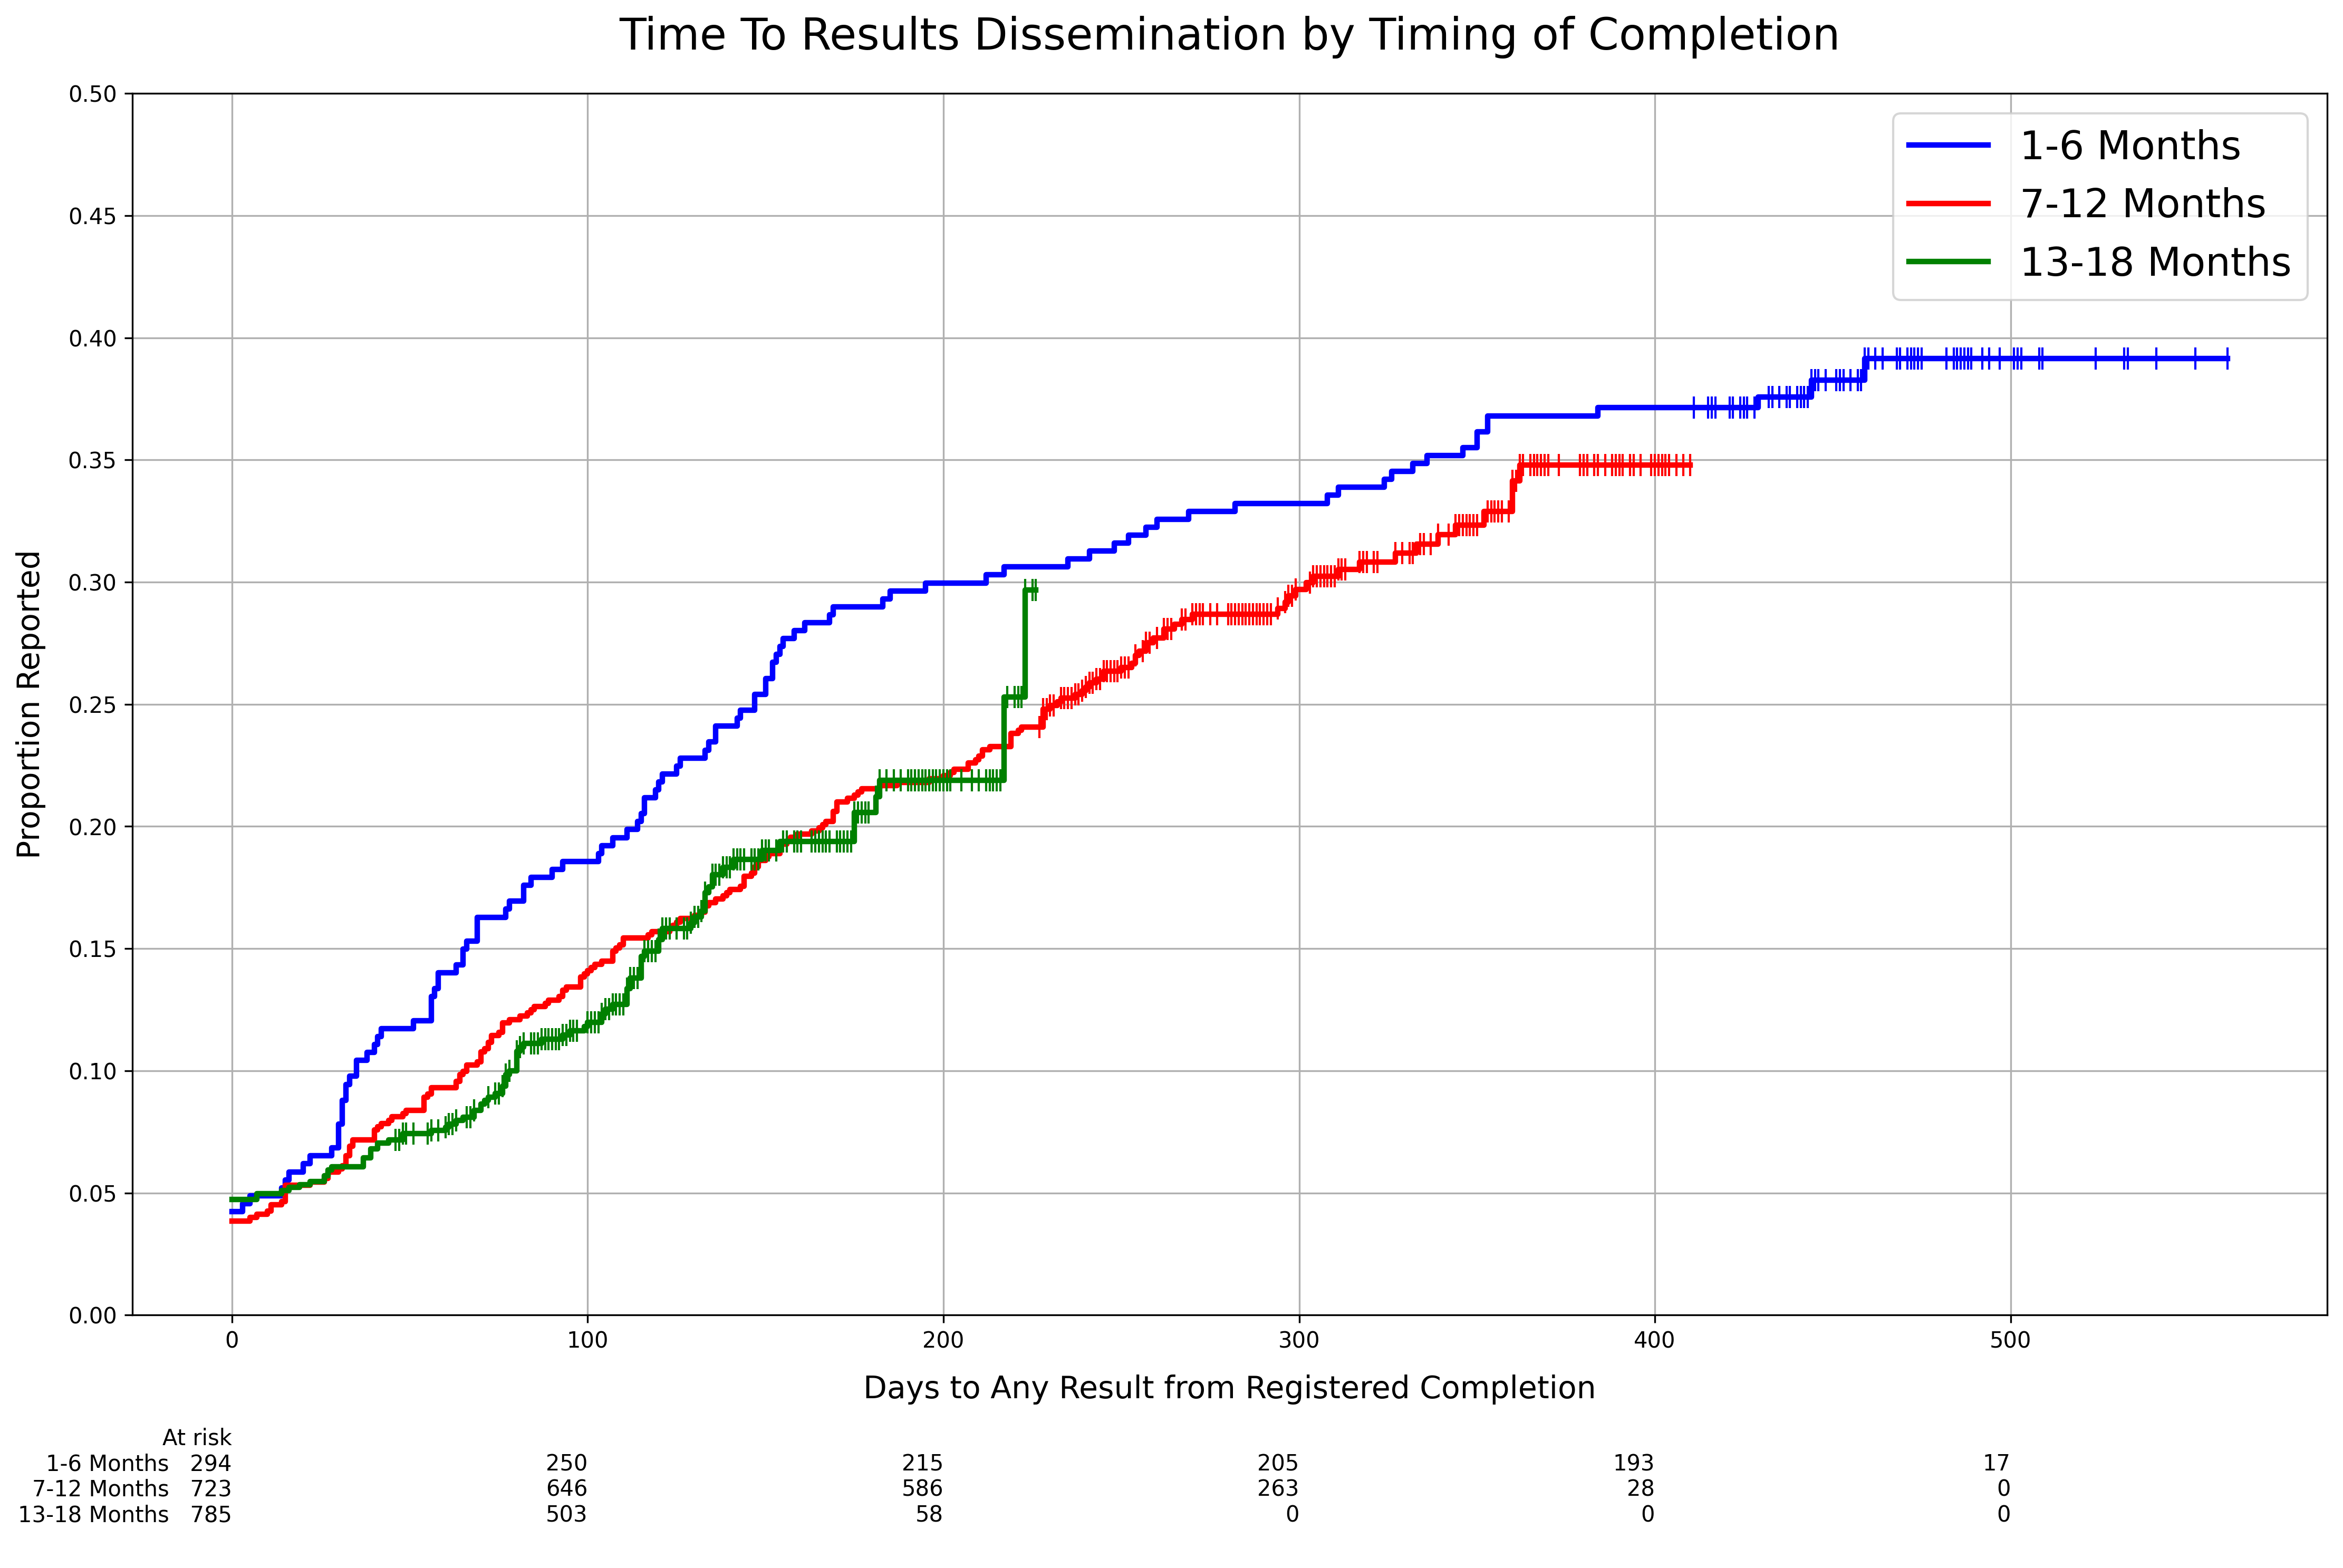

In [46]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T1 = phase_pub[phase_pub.pandemic_phase == 1].time_reporting_any_adj
E1 = phase_pub[phase_pub.pandemic_phase == 1].publication_any_adj

kmf_1 = KaplanMeierFitter()
kmf_1.fit(T1, E1, label='1-6 Months')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_1.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='blue')

T2 = phase_pub[phase_pub.pandemic_phase == 2].time_reporting_any_adj
E2 = phase_pub[phase_pub.pandemic_phase == 2].publication_any_adj

kmf_2 = KaplanMeierFitter()
kmf_2.fit(T2, E2, label='7-12 Months')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_2.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='red')


T3 = phase_pub[phase_pub.pandemic_phase == 3].time_reporting_any_adj
E3 = phase_pub[phase_pub.pandemic_phase == 3].publication_any_adj

kmf_3 = KaplanMeierFitter()
kmf_3.fit(T3, E3, label='13-18 Months')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_3.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='green')

ax.set_ylim([0, .5])

plt.title("Time To Results Dissemination by Timing of Completion", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)
ax.legend(fontsize = 18)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_1, kmf_2, kmf_3, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [47]:
#fig.savefig('pandemic_phase_reporting.png')

# Interventions

In [48]:
df_int = df2.copy()

In [49]:
top_ints = pd.read_csv(parent + '/data/interventions/top_ints.csv')
int_mapping = pd.read_csv(parent + '/data/interventions/int_mapping.csv')

In [50]:
top_ints.head(12)

,Unnamed: 0,interventions,counts
0,4,Traditional Medicine,204
1,22,Hydroxychloroquine,138
2,36,Convalescent Plasma,118
3,30,Stem Cells (Mesenchymal),50
4,81,Azithromycin,46
5,154,Ivermectin,46
6,13,Tocilizumab,41
7,0,Ritonavir,40
8,20,Favipiravir,38
9,1,Lopinavir,33


In [51]:
int_merge = df_int.merge(int_mapping, how='left', left_on='id', right_on='id').drop('Unnamed: 0', axis=1)

In [52]:
int_merge.head()

,id,date_completion,date_cutoff,publication_any,publication_article,publication_preprint,publication_summary,publication_interim_any,date_publication_any,date_publication_article,...,publication_preprint_adj,publication_article_adj,publication_summary_adj,publication_any_adj,time_publication_preprint_adj,time_publication_article_adj,time_publication_summary_adj,time_reporting_any_adj,pandemic_phase,intervention
0,tri00002,2020-04-30,2021-08-15,True,True,True,False,True,2020-03-23,2020-05-19,...,True,True,False,True,-38.0,19.0,472.0,-38.0,1,Ritonavir;Lopinavir;Umifenovir (Arbidol)
1,tri00005,2020-07-01,2021-08-15,False,False,False,False,False,NaT,NaT,...,False,False,False,False,410.0,410.0,410.0,410.0,2,Umifenovir (Arbidol)
2,tri00006,2020-04-30,2021-08-15,False,False,False,False,False,NaT,NaT,...,False,False,False,False,472.0,472.0,472.0,472.0,1,Immunoglobulin
3,tri00010,2020-06-01,2021-08-15,False,False,False,False,False,NaT,NaT,...,False,False,False,False,440.0,440.0,440.0,440.0,1,Traditional Medicine
4,tri00011,2020-06-01,2021-08-15,False,False,False,False,False,NaT,NaT,...,False,False,False,False,440.0,440.0,440.0,440.0,1,Traditional Medicine


In [53]:
#Create dummies for the most common therapies

common_therapies = ['Hydroxychloroquine', 'Convalescent Plasma', 'Stem Cells (Mesenchymal)', 'Ivermectin', 'Azithromycin']

for ct in common_therapies:
    int_merge[ct] = np.where(int_merge.intervention.str.contains(ct, regex=False), 1, 0)

In [54]:
int_merge['publication_any_adj'] = int_merge['publication_any_adj'].astype(int)
int_merge['time_reporting_any_adj'] = np.where(int_merge['time_reporting_any_adj'] < 0, 0, int_merge['time_reporting_any_adj'])

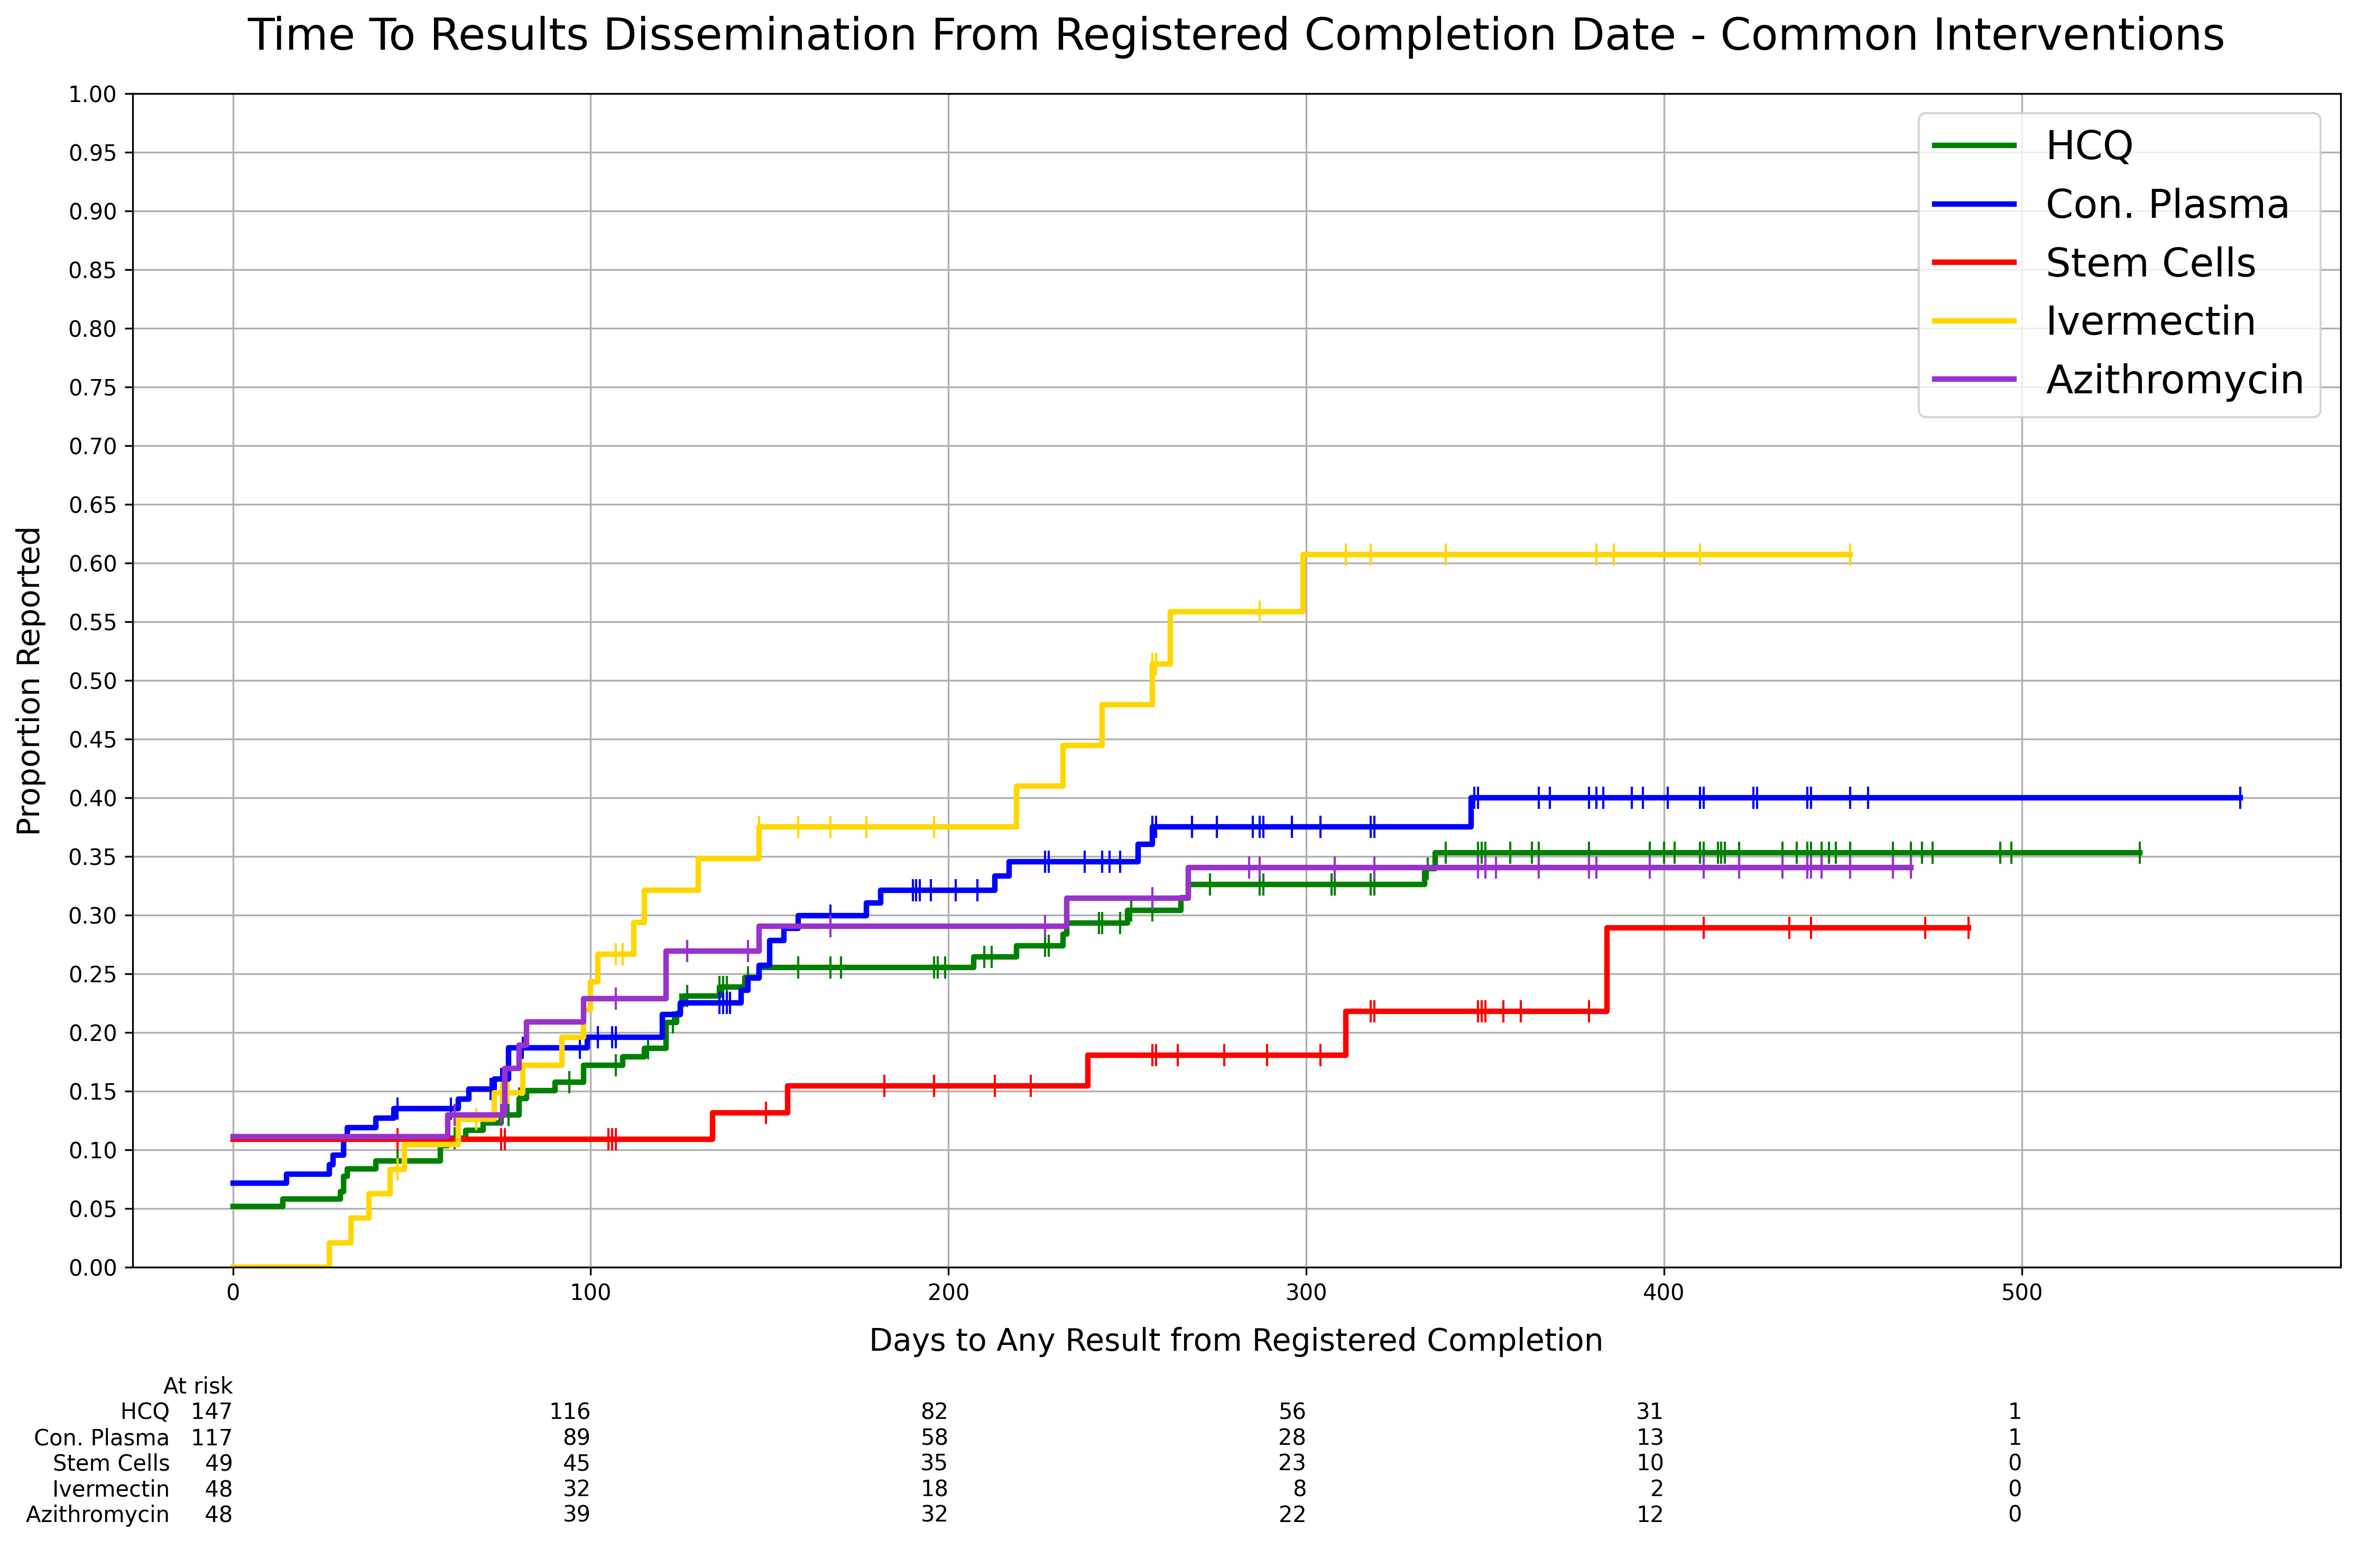

In [55]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T_hcq = int_merge[int_merge[common_therapies[0]] == 1].time_reporting_any_adj
E_hcq = int_merge[int_merge[common_therapies[0]] == 1].publication_any_adj

kmf_hcq = KaplanMeierFitter()
kmf_hcq.fit(T_hcq, E_hcq, label='HCQ')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_hcq.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='green')

T_cp = int_merge[int_merge[common_therapies[1]] == 1].time_reporting_any_adj
E_cp = int_merge[int_merge[common_therapies[1]] == 1].publication_any_adj

kmf_cp = KaplanMeierFitter()
kmf_cp.fit(T_cp, E_cp, label='Con. Plasma')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_cp.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='blue')

T_scm = int_merge[int_merge[common_therapies[2]] == 1].time_reporting_any_adj
E_scm = int_merge[int_merge[common_therapies[2]] == 1].publication_any_adj

kmf_scm = KaplanMeierFitter()
kmf_scm.fit(T_scm, E_scm, label='Stem Cells')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_scm.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='red')


T_ive = int_merge[int_merge[common_therapies[3]] == 1].time_reporting_any_adj
E_ive = int_merge[int_merge[common_therapies[3]] == 1].publication_any_adj

kmf_ive = KaplanMeierFitter()
kmf_ive.fit(T_ive, E_ive, label='Ivermectin')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_ive.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='gold')

T_azm = int_merge[int_merge[common_therapies[4]] == 1].time_reporting_any_adj
E_azm = int_merge[int_merge[common_therapies[4]] == 1].publication_any_adj

kmf_azm = KaplanMeierFitter()
kmf_azm.fit(T_azm, E_azm, label='Azithromycin')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_azm.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='darkorchid')

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date - Common Interventions", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)
ax.legend(fontsize = 18)

#from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_hcq, kmf_cp, kmf_scm, kmf_ive, kmf_azm, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [56]:
#fig.savefig('intervention_reporting.png')

# Registrations with only major results registries

In [57]:
df_reg

,id,trn,registry,ids_old,resolved
0,tri00001,NCT04246242,ClinicalTrials.gov,tri00001,NaN
1,tri00002,NCT04252885,ClinicalTrials.gov,tri00002,NaN
2,tri00003,NCT04255940,ClinicalTrials.gov,tri00003,NaN
3,tri00004,NCT04260308,ClinicalTrials.gov,tri00004,NaN
4,tri00005,NCT04260594,ClinicalTrials.gov,tri00005,NaN
...,...,...,...,...,...
10645,tri10340,PER-099-20,REPEC,tri10340,NaN
10646,tri10341,PER-101-20,REPEC,tri10341,NaN
10647,tri10342,PER-106-20,REPEC,tri10342,NaN
10648,tri10343,PER-108-20,REPEC,tri10343,NaN


In [58]:
all_reg = df_reg[['id', 'trn']].groupby('id')['trn'].apply(list).to_frame().reset_index()

In [59]:
just_results_reg = all_reg[(all_reg.trn.astype(str).str.contains('NCT')) | (all_reg.trn.astype(str).str.contains('EUCTR')) | (all_reg.trn.astype(str).str.contains('ISRCTN'))]

In [60]:
reg_pub2 = df2[['id', 'publication_summary_adj', 'time_publication_summary_adj']].reset_index(drop=True)
reg_pub2['publication_summary_adj'] = reg_pub2['publication_summary_adj'].astype(int)
reg_pub2['time_publication_summary_adj'] = np.where(reg_pub2['time_publication_summary_adj'] < 0, 0, reg_pub2['time_publication_summary_adj'])

In [61]:
#Doing an inner join here so we just get the common elements between trials on those registries, and those we searched
reg_results_df = just_results_reg.merge(reg_pub2, on='id', how='inner')

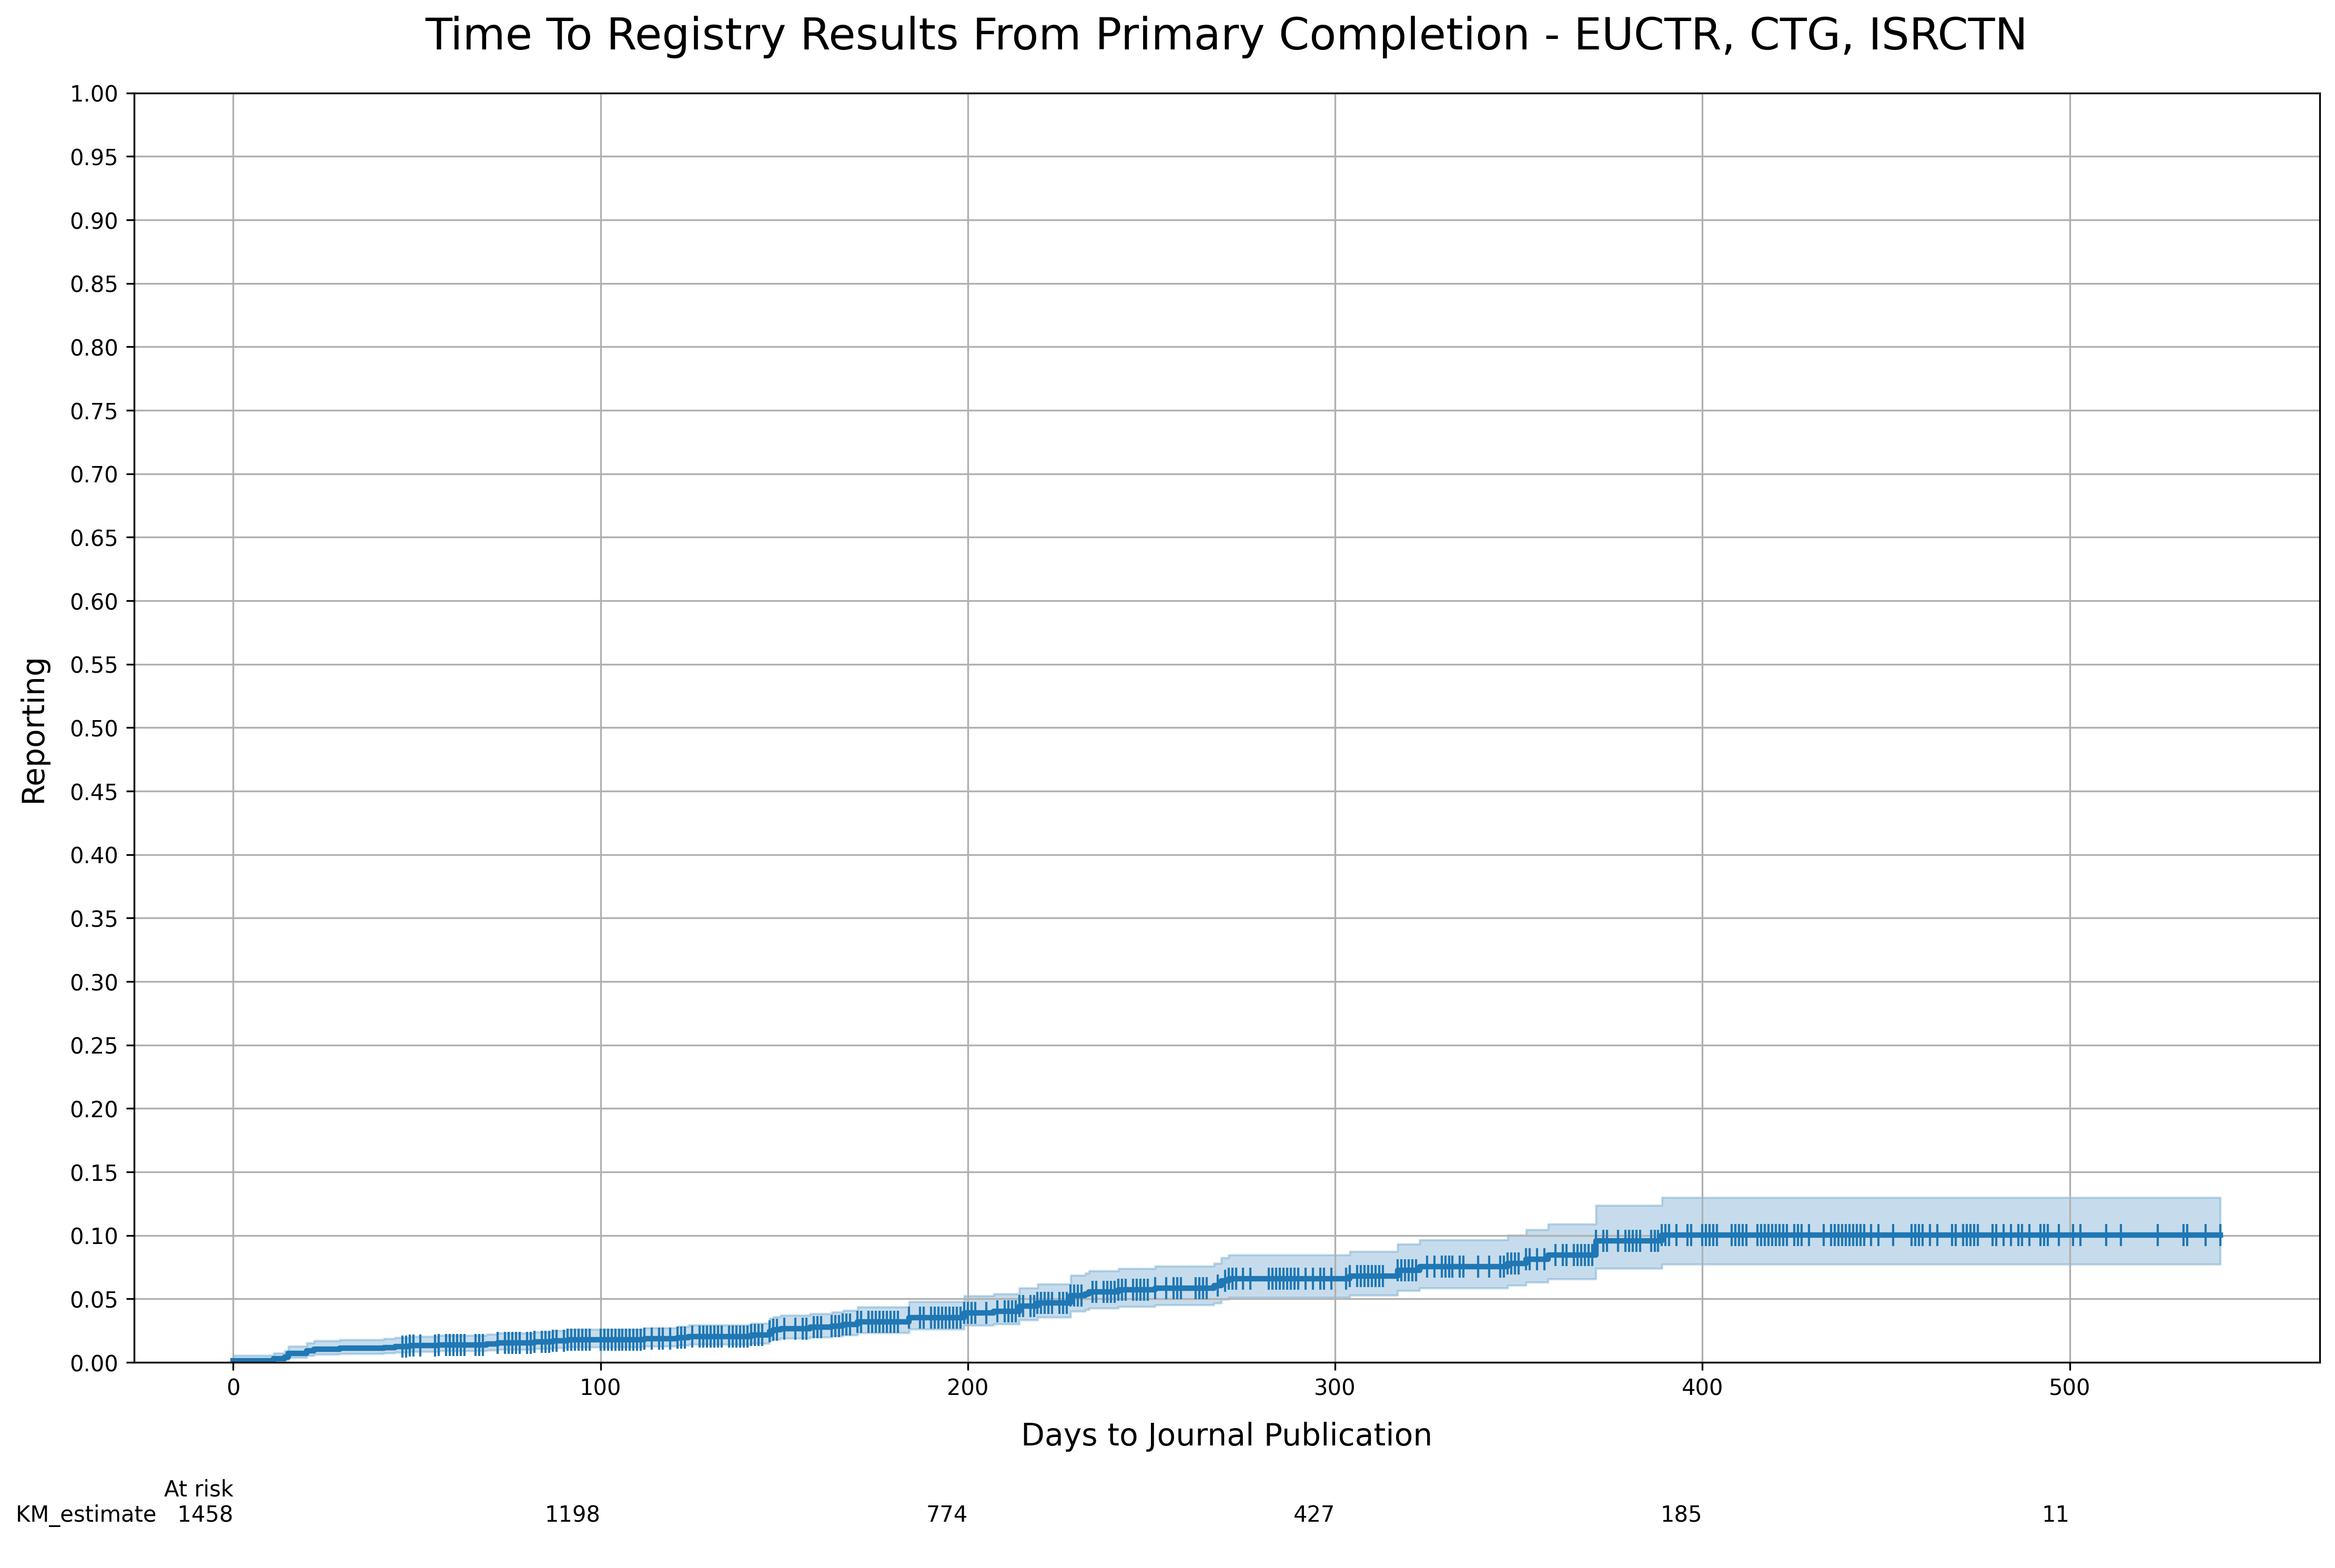

In [62]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = reg_results_df.time_publication_summary_adj
E = reg_results_df.publication_summary_adj

kmf_article = KaplanMeierFitter()
kmf_article.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_article.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Registry Results From Primary Completion - EUCTR, CTG, ISRCTN", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_article, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [63]:
#fig.savefig('registry_eu_ctg_isrctn_reporting.png')

# Pub to Preprint

In [64]:
pp_df = pd.read_csv('https://raw.githubusercontent.com/maia-sh/direcct-analysis/main/data/reporting/kaplan-meier-preprint-to-article.csv?token=GHSAT0AAAAAAB5S2YBIM7GK7ACYYMVVRF4IZBOZKRA')

In [65]:
pp_df.head()

,id,full_pub_group,date_publication_preprint,date_completion,time_cd_preprint,time_preprint_article,date_publication_article,time_cd_article,publication_article,publication_preprint,date_cutoff
0,tri03499,1,2021-05-10,2021-02-22,77,97,NaN,NaN,False,True,2021-08-15
1,tri01845,1,2021-03-31,2020-11-26,125,137,NaN,NaN,False,True,2021-08-15
2,tri02568,1,2020-07-08,2020-05-31,38,403,NaN,NaN,False,True,2021-08-15
3,tri02632,1,2021-03-29,2021-02-01,56,139,NaN,NaN,False,True,2021-08-15
4,tri02944,1,2021-07-03,2021-03-05,120,43,NaN,NaN,False,True,2021-08-15


In [66]:
pp_df.time_preprint_article.describe()

count    198.000000
mean     146.151515
std      111.769284
min        0.000000
25%       66.250000
50%      117.000000
75%      191.750000
max      557.000000
Name: time_preprint_article, dtype: float64

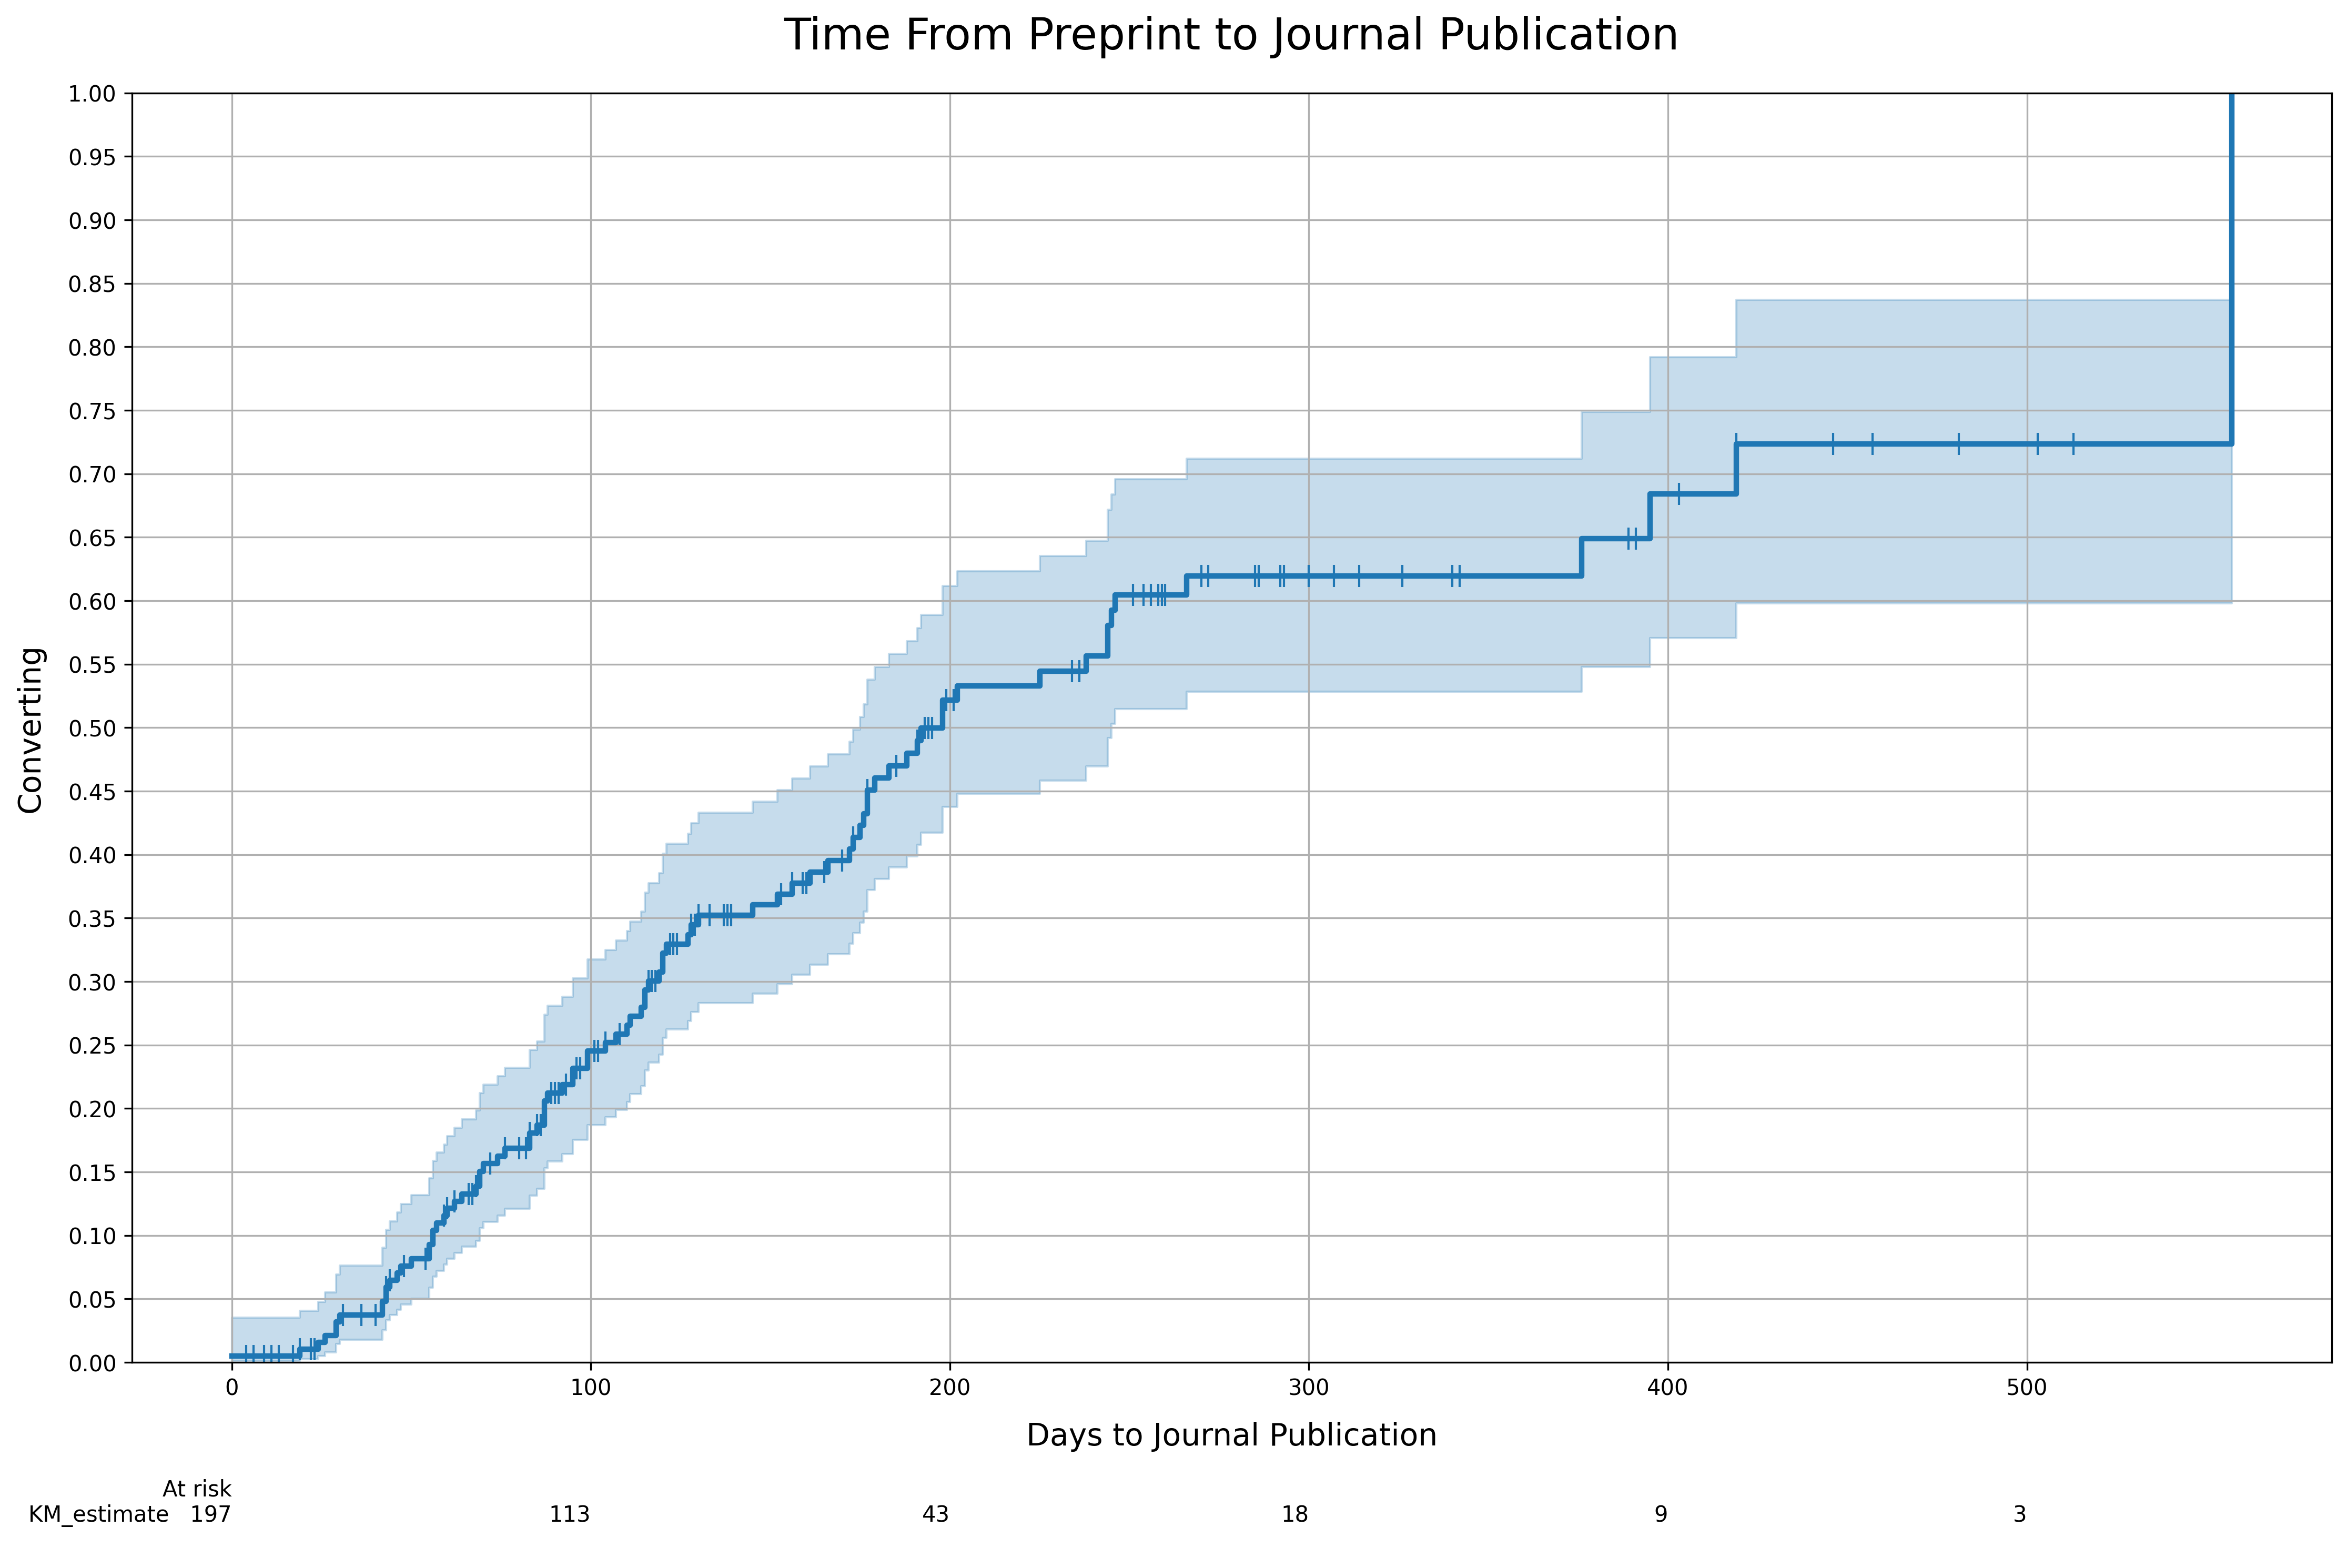

In [67]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = pp_df.time_preprint_article
E = pp_df.publication_article.astype(int)

kmf_pre_pub = KaplanMeierFitter()
kmf_pre_pub.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_pre_pub.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time From Preprint to Journal Publication", pad=20, fontsize=20)
plt.ylabel('Converting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_pre_pub, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [68]:
#fig.savefig('preprint_article_pub.png')

# Sensitivity Analysis - Only Completed Trials

In [69]:
completed = pd.read_csv('https://raw.githubusercontent.com/maia-sh/direcct-analysis/main/data/reporting/sensitivity-analyses/kaplan-meier-time-to-pub_latest_completion_status.csv')

In [70]:
completed.head()

,id,date_completion,date_cutoff,publication_any,publication_article,publication_preprint,publication_summary,publication_interim_any,date_publication_any,date_publication_article,date_publication_preprint,date_publication_summary,date_publication_interim_any,time_publication_any,time_publication_article,time_publication_preprint,time_publication_summary,time_publication_interim_any
0,tri00002,2020-04-30,2021-08-15,True,True,True,False,True,2020-03-23,2020-05-19,2020-03-23,NaN,2020-03-23,-38,19,-38,472,-38
1,tri00107,2020-12-31,2021-08-15,True,True,False,False,True,2021-07-28,2021-07-28,NaN,NaN,2021-07-28,209,209,227,227,209
2,tri00193,2020-03-09,2021-08-15,True,True,True,False,True,2020-03-24,2021-05-17,2020-03-24,NaN,2020-03-24,15,434,15,524,15
3,tri00265,2020-05-31,2021-08-15,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,441,441,441,441,441
4,tri00473,2020-03-02,2021-08-15,True,True,True,False,True,2020-08-10,2021-01-09,2020-08-10,NaN,2020-08-10,161,313,161,531,161


In [76]:
completed2 = completed[['id', 'publication_any', 'time_publication_any']].reset_index(drop=True)
completed2['publication_any'] = completed2['publication_any'].astype(int)
completed2['time_publication_any'] = np.where(completed2['time_publication_any'] < 0, 0, completed2['time_publication_any'])

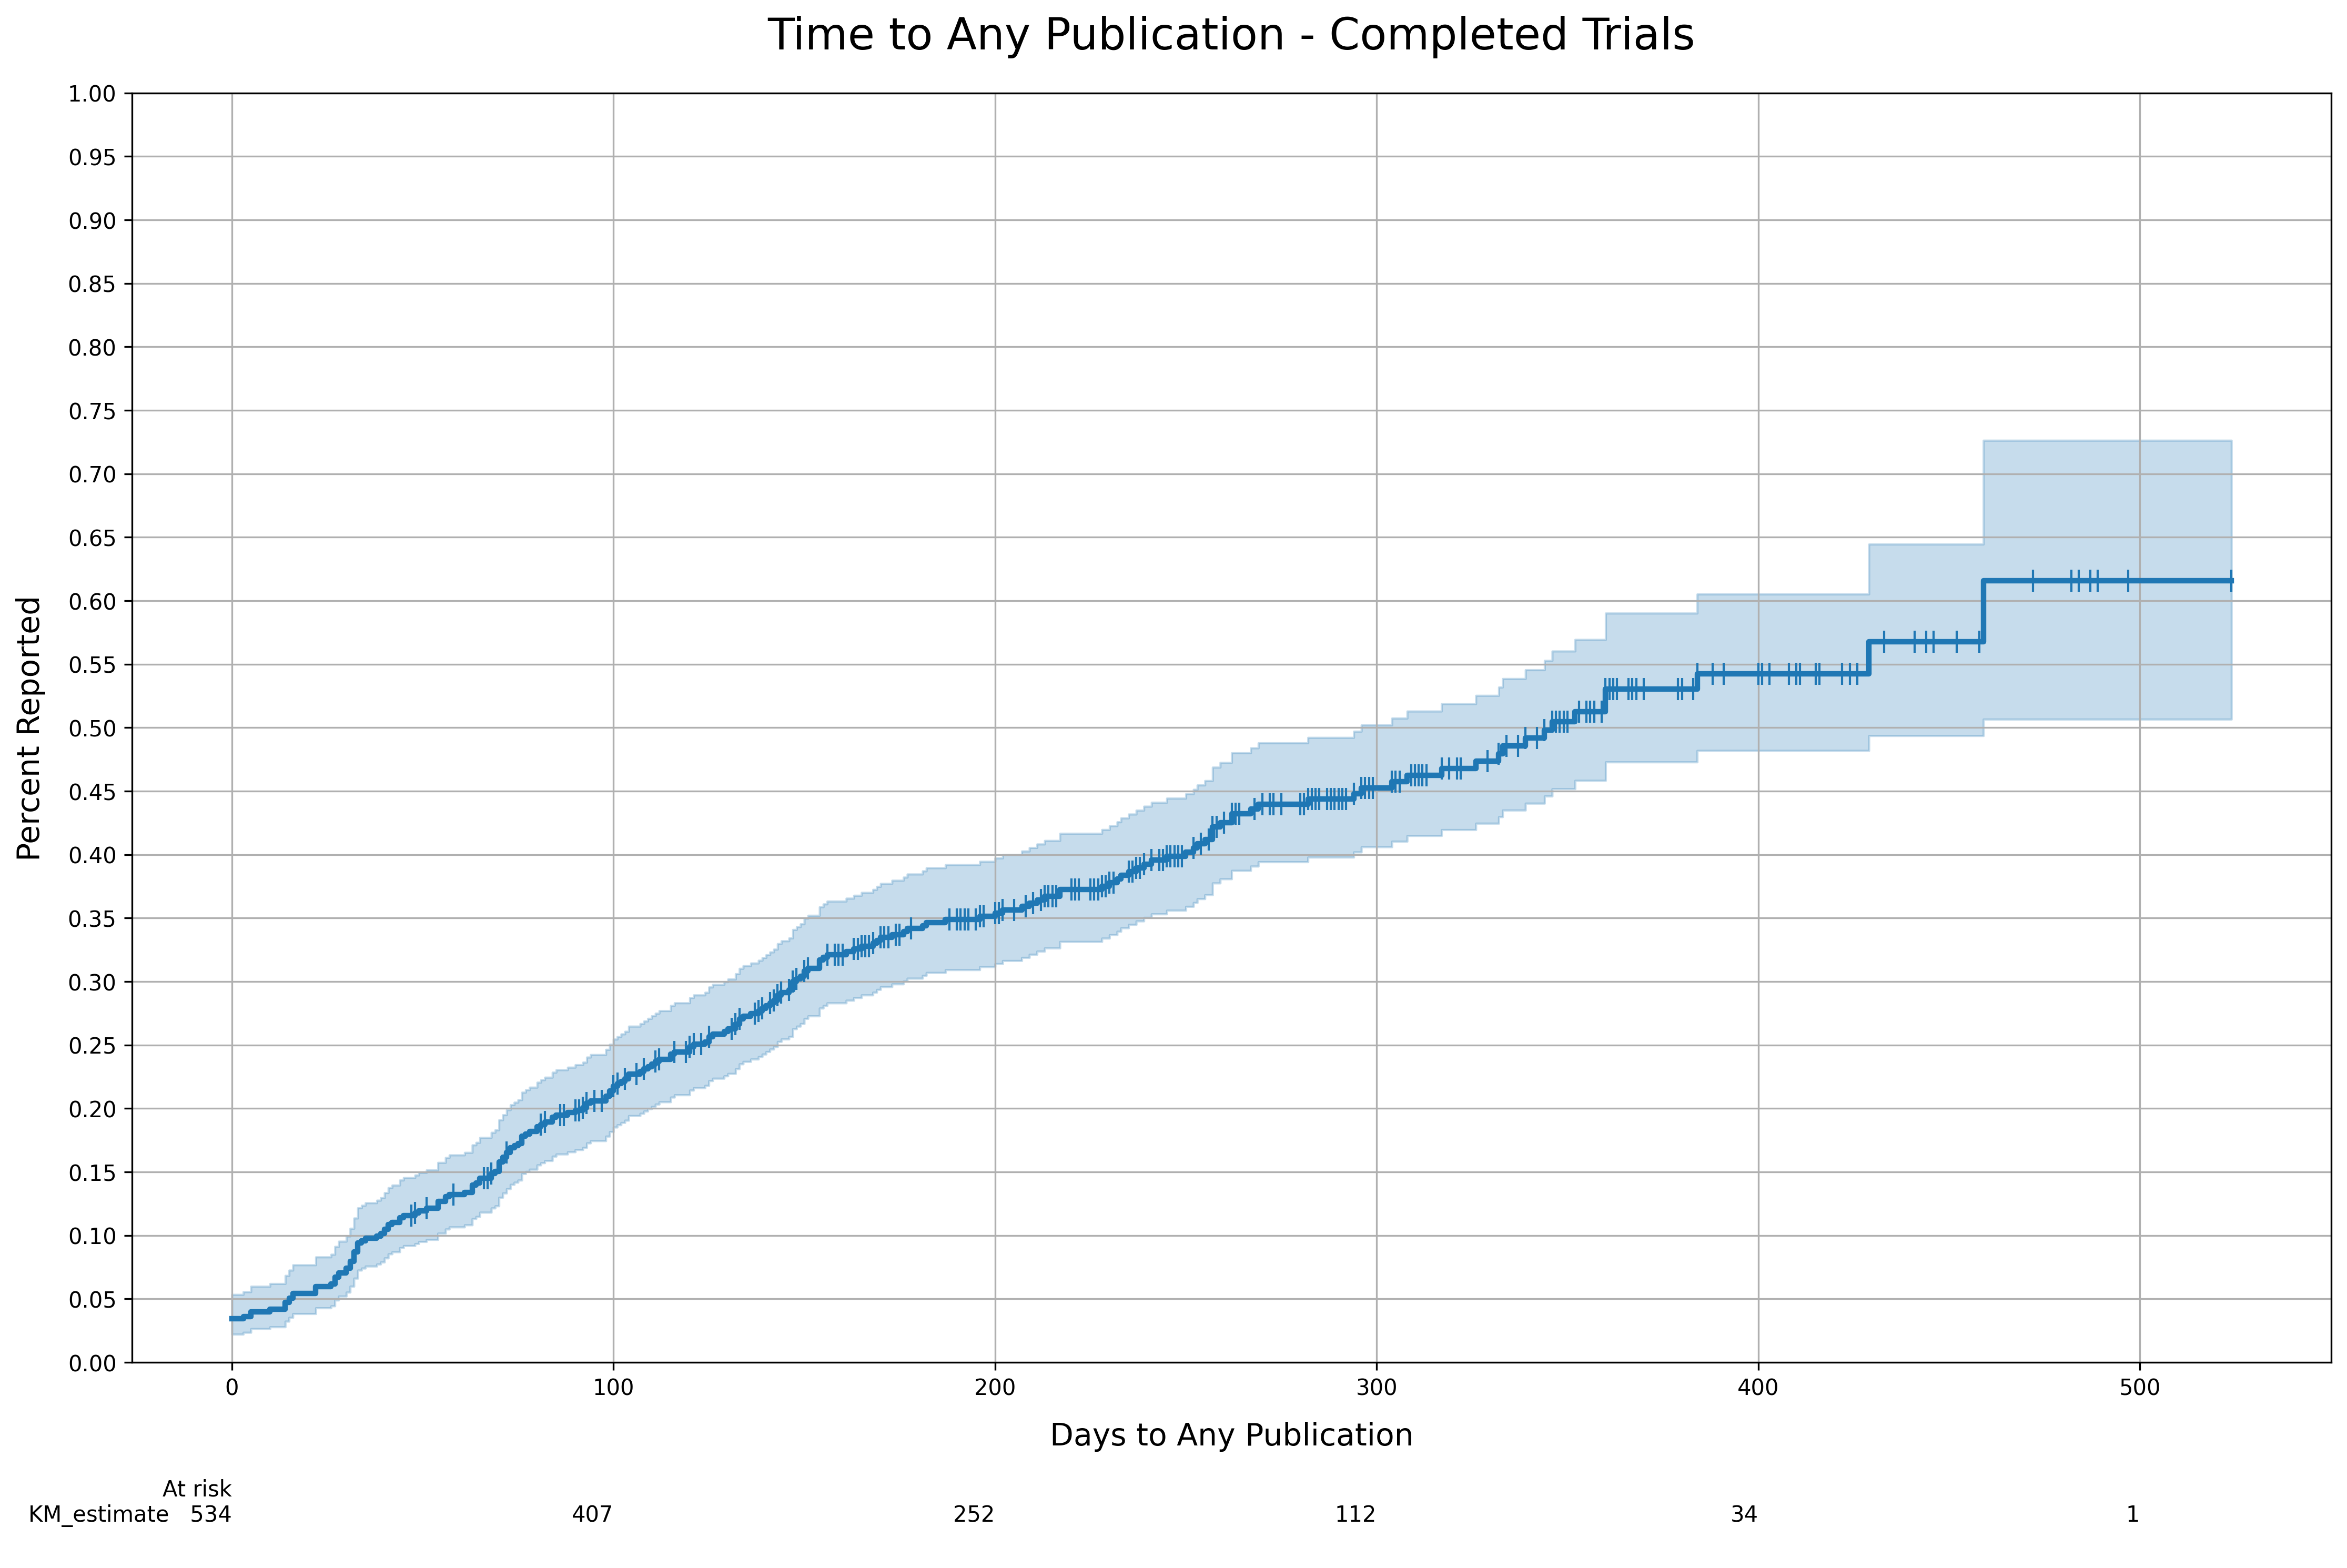

In [77]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = completed2.time_publication_any
E = completed2.publication_any

kmf_comp = KaplanMeierFitter()
kmf_comp.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_comp.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time to Any Publication - Completed Trials", pad=20, fontsize=20)
plt.ylabel('Percent Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_comp, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()